In [1]:
import os.path
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import toolsets.raw_data_scaffold as rds
import toolsets.T_rex as trx
import toolsets.spectra_operations as so
import toolsets.spectra_plotter as plotter
import toolsets.denoising_related_functions as drf
import re
import chemparse
from pubchempy import Compound, get_compounds
from toolsets.search import quick_search_values, quick_search_sorted, string_search, search_feature
import itertools
from rdkit import Chem

from molmass import Formula
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
master_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_data'

# fetching data

In [2]:
import requests

In [53]:
def get_spectra_id(master_id_name):
    url = 'http://masswiki.us-west-2.elasticbeanstalk.com/get/masswiki_data'
    data = {"wiki_id": master_id_name}
    response = requests.post(url, json=data)
    all_spectra_id=[]
    for c in response.json()['data']['spectra_data']:
        all_spectra_id.append(c['wiki_id'])
    return all_spectra_id

In [54]:
lst = get_spectra_id('b2JMB7R')

In [272]:
def get_one_spectra( spectra_id):
    url = 'http://masswiki.us-west-2.elasticbeanstalk.com/get/masswiki_data'
    data = {"wiki_id": spectra_id}
    response = requests.post(url, json=data)
    # return(response)
    data_dict = response.json()['data']
    data_dict['peaks']=so.convert_nist_to_string(data_dict['peaks'])
    dct = {k:[v] for k,v in data_dict.items()}
    dct = pd.DataFrame.from_dict(dct)
    if 'user_annotation' in response.json()['analysis'].keys():
        anno_dict = pd.DataFrame.from_dict(response.json()['analysis']['user_annotation'])
        # anno_dict = anno_dict[['method', 'rt', 'precurosr_mz', 'peaks', 'smiles', 'adduct', 'comments']]
        anno_dict.columns='matched_'+ anno_dict.columns
        dct = pd.concat([dct] * len(anno_dict), ignore_index=True)
        dct=pd.concat([dct,anno_dict], axis=1)
    #
    return dct


In [179]:
def get_all_spectra(spectra_id_list):
    spectra_all = pd.DataFrame()
    for i in tqdm(spectra_id_list):
        spectra_all = pd.concat([spectra_all, get_one_spectra(i)], ignore_index=True)
    return spectra_all

In [180]:
master_ids = ['b2JMB7R', 'b7JWOBC', 'b3M6SD1', 'bIZGW2U']#hilic neg, hilic pos,

In [275]:
output_name = ['hilic_neg', 'hilic_pos', 'c18_neg', 'c18_pos']
for i in range(0, len(master_ids)):
    all_ids = get_spectra_id(master_ids[i])
    temp = get_all_spectra(all_ids)
    temp.to_csv(os.path.join(master_dir, output_name[i]+'.csv'), index = False)

100%|██████████| 16349/16349 [46:40<00:00,  5.84it/s] 


In [280]:
look_up = []
for splash in temp['binbase-splash'].unique():
    data_temp = string_search(temp, 'binbase-splash', splash)
    if len(data_temp)>1:
        look_up.append(splash)

In [218]:
pd.DataFrame.from_dict(tt.json()['analysis']['user_annotation'])

,wiki_id,splash,method,version,rt,charge,precurosr_mz,username,name,smiles,adduct,comments,time_updated,peaks
0,b2JMB7R/PX8X5S,splash10-014i-2900000000-367172a6ed7eabc2f946,5m hilic | orbitrap | beh amide | negative,LCB2023,15.415447,-1,116.025409,Oliver Fiehn,zz delete_no EIC peak,C1C(=O)N(CS1)CC(=O)O,[M-H-CO2]-,"The compound matched with the NIST23 library, ...",2023-12-15T03:19:18.279080,NaN
1,BinBase_34d26f8d9e,splash10-014i-2900000000-367172a6ed7eabc2f946,5m hilic | orbitrap | beh amide | negative,LCB2023,16.178953,-1,116.025421,Oliver Fiehn,4-amino-7-nitrobenzofurazan,C1=C(C2=NON=C2C(=C1)[N+](=O)[O-])N,[M-H-HNO3]-,Matched with the nist20 library with ID: 42195...,2023-10-03T02:13:19,"[[65.01439666748047, 0.8458718061447144], [89...."


In [221]:
pd.concat([dct, pd.DataFrame.from_dict(tt.json()['analysis']['user_annotation'])], axis=1)

,_ms_level,peaks,binbase-splash,binbase-name,binbase-adduct,wiki_id,num peaks,scan,uuid,rt,...,rt,charge,precurosr_mz,username,name,smiles,adduct,comments,time_updated,peaks
0,2.0,50.74587631225586\t1345.5731201171875\n71.0137...,splash10-00di-9600000000-b55120d61bb80df2d950,fumaric acid,[M-H]-,b2JMB7R/LDWHQC,7.0,30.0,3.718403e+15,19.534531,...,15.415447,-1,116.025409,Oliver Fiehn,zz delete_no EIC peak,C1C(=O)N(CS1)CC(=O)O,[M-H-CO2]-,"The compound matched with the NIST23 library, ...",2023-12-15T03:19:18.279080,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.178953,-1,116.025421,Oliver Fiehn,4-amino-7-nitrobenzofurazan,C1=C(C2=NON=C2C(=C1)[N+](=O)[O-])N,[M-H-HNO3]-,Matched with the nist20 library with ID: 42195...,2023-10-03T02:13:19,"[[65.01439666748047, 0.8458718061447144], [89...."


In [7]:
mega_mona = pd.read_csv('/Users/fanzhoukong/Documents/GitHub/Libgen_data/curated_library/csv/pos_orbi_sorted.csv')

In [4]:
# def find_after_smiles(s):
#     # Convert the entire string to lowercase to ensure case-insensitive search
#     lowercase_string = s.lower()
#
#     # Find the starting index of 'smiles' in the string
#     index = lowercase_string.find('smiles')
#
#     # If 'smiles' is found in the string
#     if index != -1:
#         # Return everything after 'smiles'
#         return s[index + len('smiles='):]
#     else:
#         # If 'smiles' is not found, return an informative message or an empty string
#         return np.NAN
# smiles_rewrite = []
# for index, row in tqdm(mega_mona.iterrows(), total = len(mega_mona)):
#     if row['SMILES']!=row['SMILES']:
#         for p in row['Comments'].split('"'):
#             if 'smile' in p.lower():
#                 try:
#                     smiles = find_after_smiles(p)
#                 except:
#                     smiles = np.NAN
#         smiles_rewrite.append(smiles)
#     else:
#         smiles_rewrite.append(row['SMILES'])

In [5]:
master_validation = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_validation/mzml'

In [ ]:
from toolsets.helpers import

In [12]:

def library_search(row, mega_mona, if_commnet = False):
    pmz_candidates = quick_search_sorted(mega_mona, 'PrecursorMZ', row['precursor_mass']-0.01,
                                         row['precursor_mass']+0.01 )
    simi = np.zeros(len(pmz_candidates))
    counter = 0
    for index, r in pmz_candidates.iterrows():
        simi[counter]=simi[counter]+so.entropy_identity(r['spectrum'], row['spectrum'], pmz=row['precursor_mass'])
        counter = counter+1
    idx = np.argmax(simi)
    library_spectrum = pmz_candidates.iloc[idx]['spectrum']
    score = simi[idx]
    smiles=pmz_candidates.iloc[idx]['SMILES']
    if smiles != smiles:
        for p in pmz_candidates.iloc[idx]['Comments'].split('"'):
            if 'smile' in p.lower():
                try:
                    smiles = find_after_smiles(p)
                except:
                    smiles = np.NAN
    adduct = pmz_candidates.iloc[idx]['Precursor_type']
    if if_commnet==False:
        return library_spectrum, score, smiles,adduct
    else:
        return library_spectrum, score, smiles,adduct, pmz_candidates.iloc[idx]['Comments']

In [13]:
library_spectra = []
library_smiles = []
library_adducts = []
scores = []

for index, row in tqdm(lcb_df.iterrows(), total = len(lcb_df)):
    library_spectrum, score, smile, adduct = library_search(row, mega_mona)
    library_adducts.append(adduct)
    library_spectra.append(library_spectrum)
    library_smiles.append(smile)
    scores.append(score)
lcb_df['library_spectra']=library_spectra
lcb_df['library_smiles']=library_smiles
lcb_df['library_adducts']=library_adducts
lcb_df['scores']=scores

100%|██████████| 33/33 [00:14<00:00,  2.21it/s]


In [45]:
msms_d = []
eis = []
entropy_denoised = []
for index, row in tqdm(lcb_df.iterrows(), total = len(lcb_df)):
    denoised = drf.spectra_denoising(row['spectrum'], row['library_smiles'],row['library_adducts'])
    msms_d.append(denoised[0])
    eis.append(denoised[1])
    entropy_denoised.append(so.entropy_identity(denoised[0],row['library_spectra'], pmz=drf.calculate_precursormz(row['library_smiles'], row['library_adducts'], if_smiles=True)) )
lcb_df['entropy_denoised']=entropy_denoised
lcb_df['msms_d']=msms_d

100%|██████████| 33/33 [00:00<00:00, 117.99it/s]


In [69]:
lcb_df['entropy_offset']=lcb_df['entropy_denoised']-lcb_df['scores']

In [100]:
lcb_df[lcb_df['entropy_offset']<0]

,preferred_name,retention_index,precursor_mass,pre_cursors_intensity,preferred_adduct,splash,method,sample,scan_count,signal_noise,...,suggested_type,suggested_other_metadata,spectrum,library_spectra,library_smiles,library_adducts,scores,entropy_denoised,msms_d,entropy_offset
4,4-oxosebacic acid,21.942979,199.086523,803193.0,NaN,splash10-0f7k-0900000000-2e07d685eed5417169e8,5m hilic | orbitrap | beh amide | positive,Schebesta0234_MX741718_posBA_nfCLBHIP3-801,69,45.452011,...,NaN,NaN,70.065139\t99573.0\n70.069472\t2952.0\n74.0600...,55.0183\t1.4\n55.0548\t1.7\n67.0547\t1.0\n71.0...,CCCC(O)c1ccc(=O)oc1CO,[M+H]+,0.295400,0.098693,70.065139\t99573.0\n70.069472\t2952.0\n74.0600...,-0.196707
16,unknown_180.0881_33.66,33.662608,180.088061,4700251.5,NaN,splash10-001i-0900000000-dd14666d1d640530f2b0,5m hilic | orbitrap | beh amide | positive,Schebesta0608_MX741718_posBA_miRBHIP3-788,-1,-1.000000,...,NaN,NaN,64.005661\t1380.123901\n71.060454\t9812.618164...,55.029\t19.2\n71.0601\t82.0\n82.0398\t9.8\n110...,CN(C)c1nc2c(ncn2C2OC(CO)C(O)C2O)c(=O)[nH]1,[M+H-C5H8O4]+,0.693434,0.648250,71.060454\t9812.618164\n80.049474\t104620.4062...,-0.045184
28,glutamine hydroxamate,146.654480,130.049884,8695008.0,[M+H-H3NO]+,splash10-0a59-9600000000-d38fe315c3b64e586e6d,5m hilic | orbitrap | beh amide | positive,Schoeman0046_MX749154_posBA_FD08073720-016,51,34.345322,...,NaN,NaN,56.049712\t896816.0\n57.057637\t3654.0\n57.070...,56.05033\t0.729701\n57.07066\t1.640989\n74.097...,O=C(O)C1N=C(O)CC1,[M+H]+,0.635845,0.454287,56.049712\t896816.0\n57.057637\t3654.0\n73.028...,-0.181558


In [97]:
row = lcb_df.loc[12]

In [105]:
row = lcb_df.loc[4]
tt = drf.spectra_denoising(row['library_spectra'], row['library_smiles'], row['library_adducts'])

In [130]:
row = lcb_df.loc[4]
ttt = drf.spectra_denoising(row['spectrum'], row['library_smiles'], row['library_adducts'])

In [147]:
drf.find_actual_parent_pmz(row['library_spectra'], drf.calculate_precursormz(row['library_smiles'], row['library_adducts'], if_smiles=True))

199.0978

In [155]:
row = string_search(lcb_df, 'splash', 'splash10-000i-0920000000-2e4a7b4878c8d7900676').iloc[0]

In [164]:
so.convert_string_to_nist(row['spectrum'])

array([[5.52512790e+01, 2.39800000e+03],
       [5.70338840e+01, 4.27500000e+03],
       [7.20808780e+01, 5.99700000e+03],
       [7.40601260e+01, 5.98300000e+03],
       [7.45604290e+01, 2.66100000e+03],
       [8.50284380e+01, 3.15200000e+03],
       [9.80966030e+01, 8.50000000e+03],
       [1.09268879e+02, 2.43500000e+03],
       [1.15039762e+02, 2.44100000e+03],
       [1.16107141e+02, 9.69300000e+03],
       [1.21715838e+02, 2.81200000e+03],
       [1.33049513e+02, 5.96900000e+03],
       [1.36061922e+02, 4.94004000e+05],
       [1.45064910e+02, 6.54500000e+03],
       [1.65054764e+02, 6.56600000e+03],
       [1.70584254e+02, 2.52900000e+03],
       [1.91070184e+02, 2.66990000e+04],
       [2.26107300e+02, 1.05020000e+04],
       [2.50144807e+02, 2.66100000e+03],
       [2.61669269e+02, 2.78800000e+03],
       [2.68105006e+02, 4.13270000e+04],
       [2.68154169e+02, 1.02756000e+05]])

In [169]:
drf.find_actual_parent_pmz(row['spectrum'], drf.calculate_precursormz(row['library_smiles'], row['library_adducts'], if_smiles=True))-136.061922

132.09224700000001

In [168]:
 drf.calculate_precursormz(row['library_smiles'], row['library_adducts'], if_smiles=True)

268.15433461186075

In [186]:
from toolsets.helpers import save_mol_image

In [177]:
lcb_df.sort_values(by = 'entropy_offset', ascending=False)

,preferred_name,retention_index,precursor_mass,pre_cursors_intensity,preferred_adduct,splash,method,sample,scan_count,signal_noise,...,suggested_type,suggested_other_metadata,spectrum,library_spectra,library_smiles,library_adducts,scores,entropy_denoised,msms_d,entropy_offset
32,melamine,66.493497,127.072709,2.880185e+06,[M+H]+,splash10-004i-1900000000-c446a7205254c9005f00,5m hilic | orbitrap | beh amide | positive,PoolQC073_MX741718_posBA_postSchebesta0711,-1,-1.000000,...,NaN,NaN,68.024353\t1725.247437\n81.06991\t1852.798462\...,60.0556\t5.706168\n68.0243\t22.533342\n85.0509...,N=C1NC(=N)NC(=N)N1,[M+H]+,0.515200,0.773061,68.024353\t1725.247437\n85.05084\t61537.753906...,0.257861
5,N8-acetylspermidine,127.238931,188.175881,4.885508e+06,NaN,splash10-0079-0900000000-e4e2005f9f23845b13fd,5m hilic | orbitrap | beh amide | positive,PoolQC038_MX741718_posBA_postSchebesta0366,-1,-1.000000,...,NaN,NaN,72.080747\t53165.605469\n84.081036\t2077.80322...,58.0653\t12.7\n72.0441\t12.2\n72.0805\t16.2\n7...,CC(=O)NCCCCNCCCN,[M+H]+,0.625870,0.841261,72.080747\t53165.605469\n84.081036\t2077.80322...,0.215391
0,glycodeoxycholic acid,74.852023,472.303318,7.362711e+06,[M+Na]+,splash10-00di-0000900000-10ff239479c8a94c1e22,5m hilic | orbitrap | beh amide | positive,Schoeman0185_MX749154_posBA_FD08075314-172,84,147254.218800,...,NaN,NaN,52.476052\t78604.0\n52.479104\t20535.0\n56.624...,98.0214\t42.8\n397.2726\t159.8\n415.2834\t2.5\...,CC(CCC(=O)NCC(=O)O)C1CCC2C3CCC4CC(O)CCC4(C)C3C...,[M+Na]+,0.675519,0.769729,86.033776\t6854.0\n98.021349\t50157.0\n106.992...,0.094210
15,meropenem,111.383045,406.140680,2.155602e+05,[M+Na]+,splash10-02t9-5639400000-8eaa5d19c2319bb3bf3a,5m hilic | orbitrap | beh amide | positive,PoolMSMS001_MX765259_posBA_AFV_IE3,-1,-1.000000,...,NaN,NaN,58.62026\t325.138855\n61.964368\t343.102295\n7...,68.0489\t6.6\n119.0573\t7.2\n123.0521\t21.2\n1...,CC(O)C1C(=O)N2C(C(=O)O)=C(SC3CNC(C(=O)N(C)C)C3...,[M+Na]+,0.662493,0.745637,61.964368\t343.102295\n77.068984\t334.849396\n...,0.083144
26,unknown_109.0761_52.91,52.908799,109.076108,2.534238e+06,NaN,splash10-0a4i-0900000000-26b1e91833b5d93ae39d,5m hilic | orbitrap | beh amide | positive,Schebesta0024_MX741718_posBA_anDMM9P3-592,-1,-1.000000,...,NaN,NaN,63.06304\t2491.884033\n66.091405\t1803.045044\...,65.0383\t1.3\n67.0414\t1.2\n68.0492\t3.4\n69.0...,CCc1cnccn1,[M+H]+,0.711363,0.791884,68.049573\t12927.9375\n69.044835\t1846.421631\...,0.080521
8,unknown_268.1543_86.60,86.598507,268.154322,1.810660e+06,NaN,splash10-000i-0920000000-2e4a7b4878c8d7900676,5m hilic | orbitrap | beh amide | positive,Jepsen_PoolMSMS_003_MX677489_posBA,36,36132.796880,...,NaN,NaN,55.251279\t2398.0\n57.033884\t4275.0\n72.08087...,56.0492\t38.6\n58.0648\t5.4\n60.0805\t2.1\n72....,CC(C)NCC(O)COc1ccc(CC(=O)O)cc1,[M+H]+,0.561434,0.632184,57.033884\t4275.0\n72.080878\t5997.0\n74.06012...,0.070750
3,unknown_116.1070_51.85,51.852683,116.107023,6.778009e+05,NaN,splash10-014i-1900000000-94f4bb863d1b42df7e24,5m hilic | orbitrap | beh amide | positive,Jepsen_A2CPS0013_MX781775_posBA_L7L9Ao9j1yy6n-014,-1,-1.000000,...,NaN,NaN,70.065124\t3765.285645\n71.072975\t1790.7677\n...,58.0654\t1.0\n70.0652\t3.4\n71.0731\t1.4\n72.0...,CN(C)CCOCCN(C)C,[M+H-C2H7N]+,0.667964,0.730821,70.065124\t3765.285645\n71.072975\t1790.7677\n...,0.062858
29,unknown_552.4019_80.81,80.807483,552.401910,7.654300e+04,NaN,splash10-0f8i-3910000000-8e81219ef34db8d7451b,5m hilic | orbitrap | beh amide | positive,PoolMSMS001_MX754573_posBA_Jepsen_A2CPS_IE_6,70,1530.869995,...,NaN,NaN,70.429132\t1455.0\n86.096366\t5733.0\n88.38088...,86.0965\t2.2\n104.1073\t4.8\n125.0002\t1.0\n18...,CCCCCCCCCCCCCCCCCCOCC(COP(=O)([O-])OCC[N+](C)(...,[M+H]+,0.671640,0.734326,86.096366\t5733.0\n104.106884\t6579.0\n124.999...,0.062687
19,ofloxacin N-oxide,63.141390,378.146110,1.339990e+05,NaN,splash10-02vi-2029000000-7ba145242467c235a1af,5m hilic | orbitrap | beh amide | positive,AFV0061_MX765259_posBA_B16-242-T21,-1,-1.000000,...,NaN,NaN,57.496831\t469.756104\n70.065179\t1608.23071

entropy similarity is  0.6624930604033412
entropy similarity is  0.7456369773577936


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

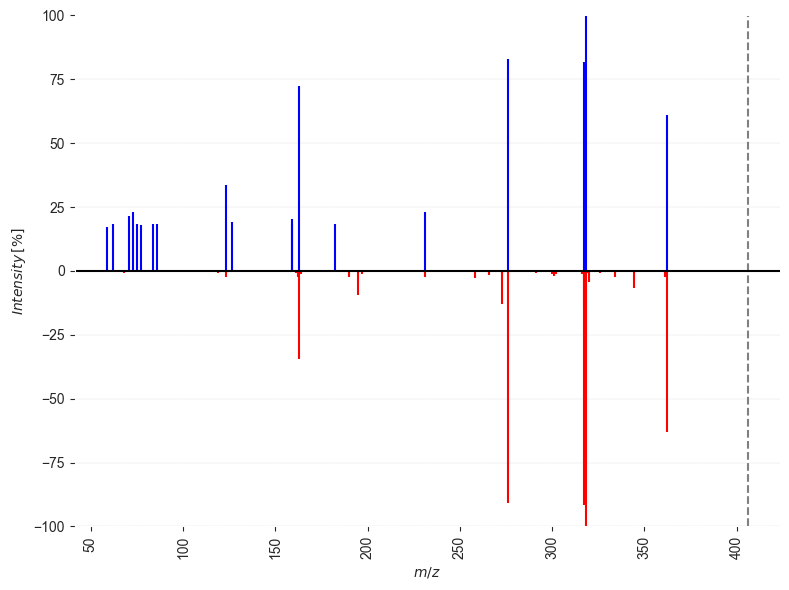

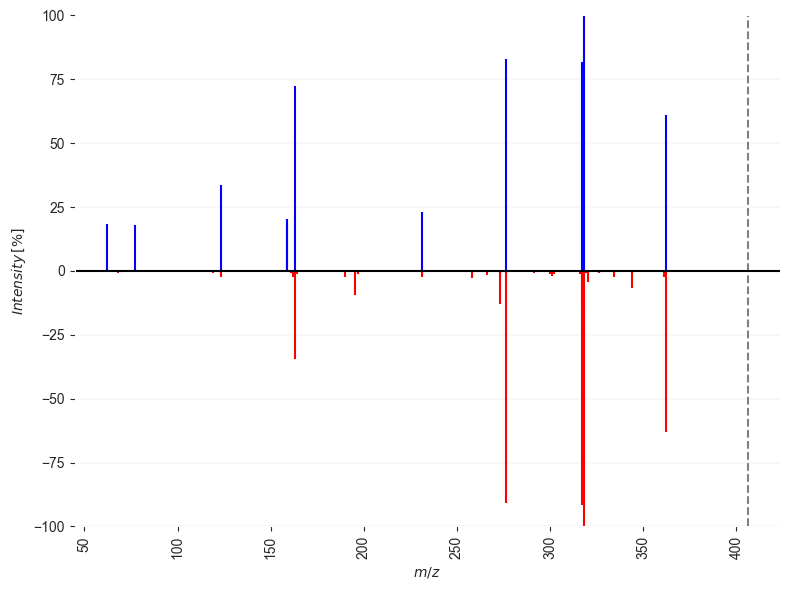

In [194]:
row = lcb_df.loc[15]
# save_mol_image(row['smiles'], savepath=os.path.join(master_dir, 'good_mol_1.png'))
plotter.head_to_tail_plot(row['spectrum'],row['library_spectra'] ,pmz=row['precursor_mass'],
                          # savepath=os.path.join(master_dir, 'good_raw_1.png')
                          )
plotter.head_to_tail_plot(row['msms_d'],row['library_spectra'] ,pmz=row['precursor_mass'],
                          # savepath=os.path.join(master_dir, 'good_denoised_1.png')
                          )

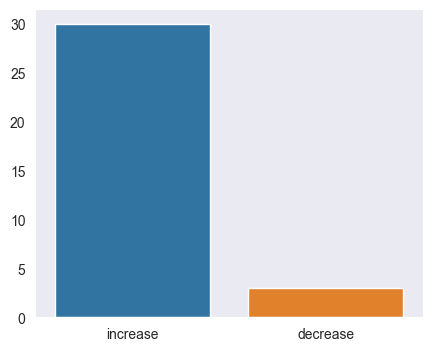

In [191]:
fig = plt.figure(figsize = (5, 4))#43
x = ['increase', 'decrease']
y = [30, 3]
ax = sns.barplot(x=x, y=y)
ax.grid(False)
plt.savefig(os.path.join(master_dir, 'updown.png'), dpi = 300,facecolor = 'white', edgecolor = 'none')

In [178]:
row = lcb_df.loc[32]
save_mol_image(row['smiles'], savepath=os.path.join(master_dir, 'good_mol_1.png'))
plotter.head_to_tail_plot(row['spectrum'],row['library_spectra'] ,pmz=row['precursor_mass'],
                          # savepath=os.path.join(master_dir, 'good_raw_1.png')
                          )
plotter.head_to_tail_plot(row['msms_d'],row['library_spectra'] ,pmz=row['precursor_mass'],
                          # savepath=os.path.join(master_dir, 'good_denoised_1.png')
                          )

entropy similarity is  0.6258699040358502
entropy similarity is  0.8412606287533357


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

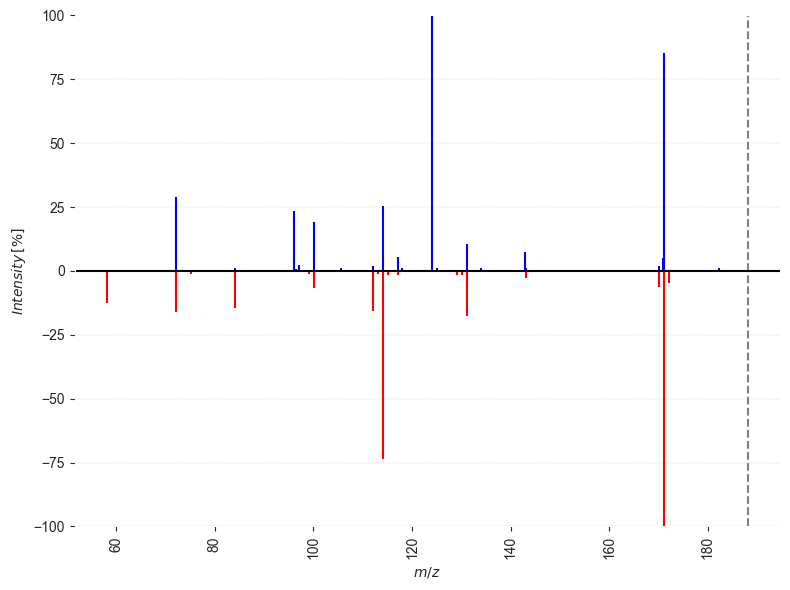

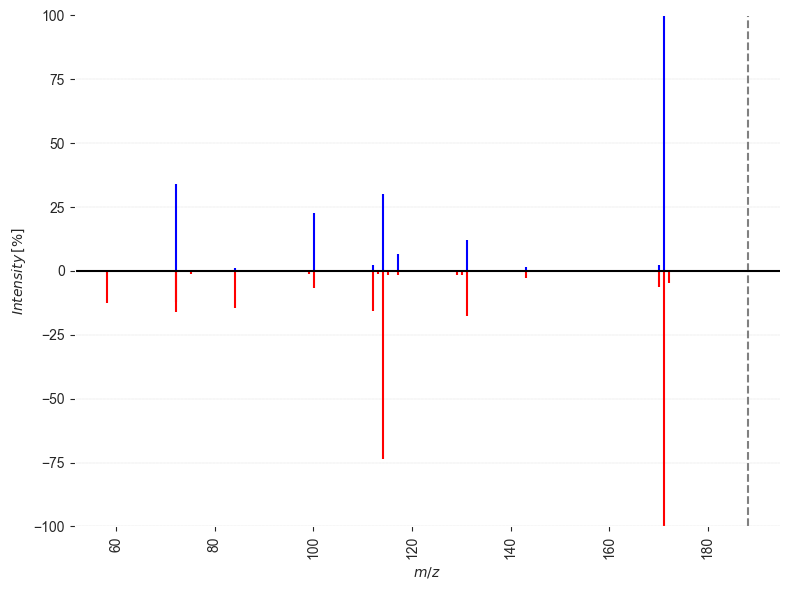

In [187]:
row = lcb_df.loc[5]
save_mol_image(row['smiles'], savepath=os.path.join(master_dir, 'good_mol_2.png'))
plotter.head_to_tail_plot(row['spectrum'],row['library_spectra'] ,pmz=row['precursor_mass'],
                          savepath=os.path.join(master_dir, 'good_raw_2.png')
                          )
plotter.head_to_tail_plot(row['msms_d'],row['library_spectra'] ,pmz=row['precursor_mass'],
                          savepath=os.path.join(master_dir, 'good_denoised_2.png')
                          )

entropy similarity is  0.5361313924614368


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

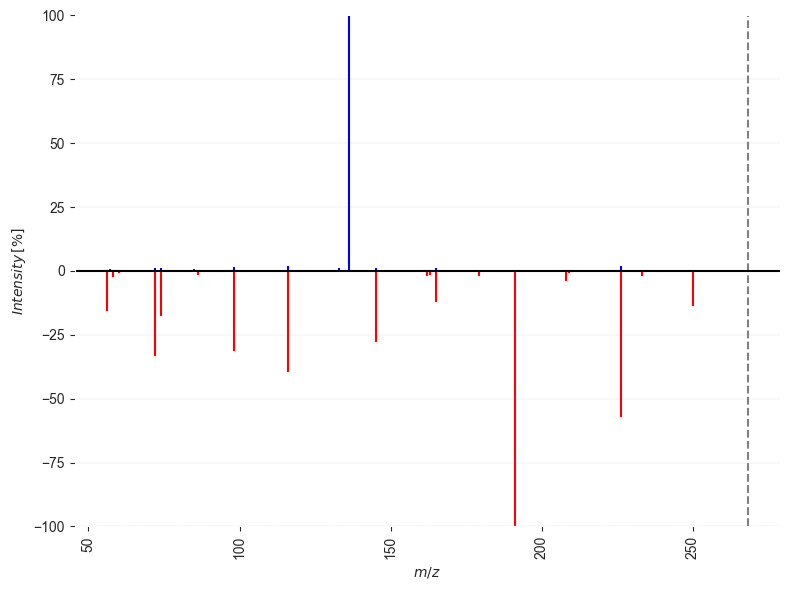

In [29]:
plotter.head_to_tail_plot(row['msms_d'], row['library_spectra'], pmz = 268.154175)

In [28]:
row

preferred_name                                                  unknown_268.1543_86.60
retention_index                                                              86.598507
precursor_mass                                                              268.154322
pre_cursors_intensity                                                        1810660.0
preferred_adduct                                                                   NaN
splash                                   splash10-000i-0920000000-2e4a7b4878c8d7900676
method                                      5m hilic | orbitrap | beh amide | positive
sample                                              Jepsen_PoolMSMS_003_MX677489_posBA
scan_count                                                                          36
signal_noise                                                               36132.79688
peak_gaussion_similarity                                                           NaN
peak_pure                                  

In [331]:
drf.check_ratio('HN3O')

True

In [329]:
616.176818-557.163696

59.01312200000007

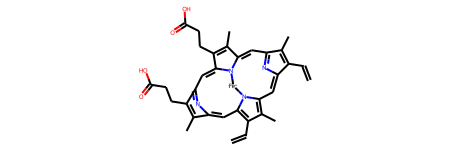

In [324]:
Chem.MolFromSmiles(row['library_smiles'])

In [326]:
smile_to_formula((row['library_smiles']))

'C34H32FeN4O4+'

In [321]:
616.176818-557.163696

59.01312200000007

entropy similarity is  0.6494021886848362


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

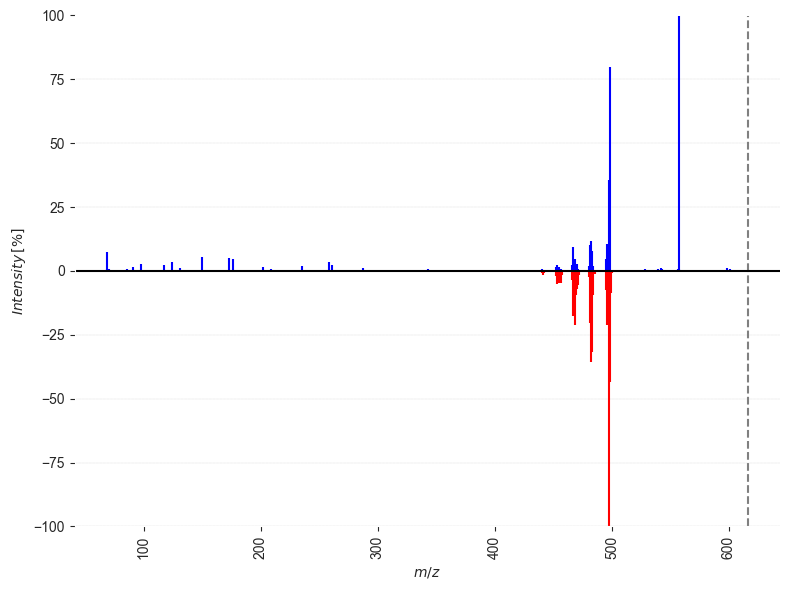

In [316]:
plotter.head_to_tail_plot(row['spectrum'], row['library_spectra'], pmz=row['precursor_mass'])

entropy similarity is  0.6935480456042915
entropy similarity is  0.8899369088255655


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

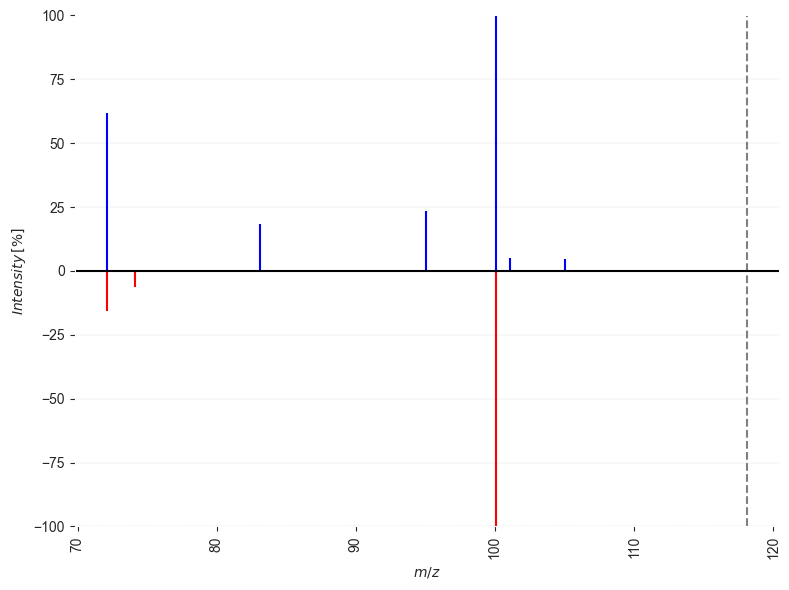

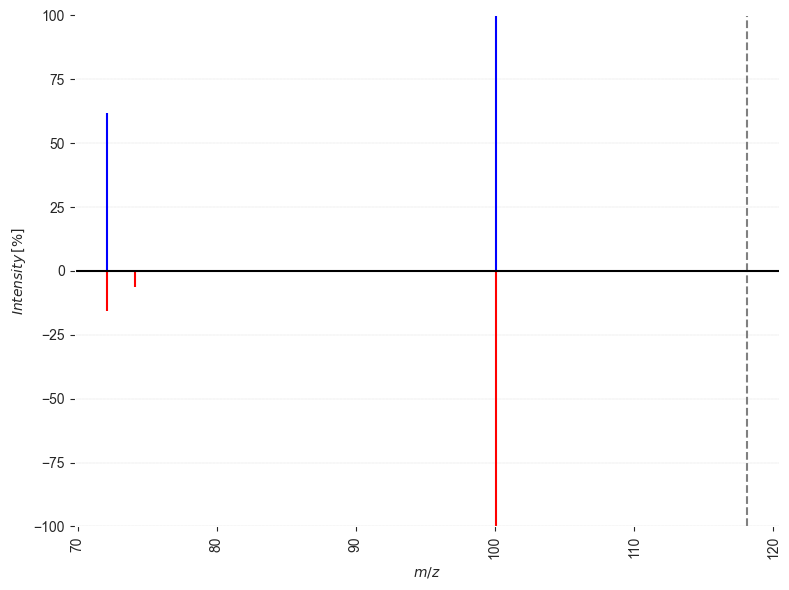

In [306]:
row = lcb_df.loc[30]
plotter.head_to_tail_plot(row['spectrum'], row['library_spectra'], pmz=row['precursor_mass'])
plotter.head_to_tail_plot(row['msms_d'], row['library_spectra'], pmz=row['precursor_mass'])

entropy similarity is  0.6663835819790387


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

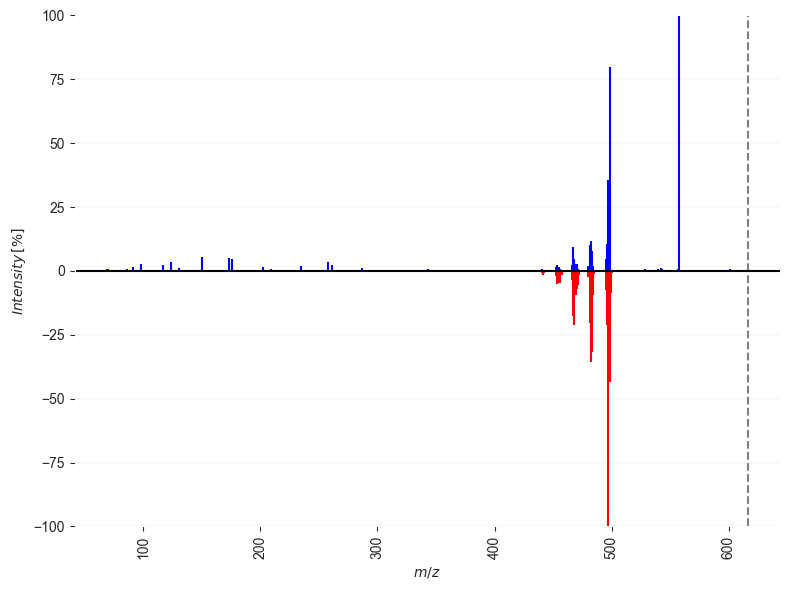

In [261]:
denoised = drf.spectra_denoising(row['library_spectra'], row['library_smiles'],row['library_adducts'])

In [268]:
mass_d, intensity_d = so.break_spectra(denoised[0])
mass_l, intensity_l = so.break_spectra(row['library_spectra'])

In [273]:
smile_to_formula(row['library_smiles'])

'C10H14O4'

In [269]:
def find_unique_elements(array1, array2):
    # Convert arrays to sets
    set1 = set(array1)
    set2 = set(array2)

    # Find elements that are unique to each set (symmetric difference)
    unique_elements = set1.symmetric_difference(set2)

    # Convert the set back to a list if you need a list format
    return list(unique_elements)

In [275]:
drf.calculate_precursormz(row['library_smiles'],row['library_adducts'], if_mol=True)

199.09648538182074

In [270]:
find_unique_elements(mass_d, mass_l)

[145.0659, 119.05, 163.0765, 117.0707]

In [278]:
mass_parent[0]

199.090475

In [281]:
199.09648538182074-117.0707

82.02578538182074

In [282]:
199.090475-117.0707

82.019775

In [248]:
drf.calculate_precursormz(row['library_smiles'], row['library_adducts'], if_mol=True)

199.09648538182074

In [249]:
199.086523-199.09648538182074

-0.009962381820741939

In [240]:
drf.prep_formula(smile_to_formula(row['library_smiles']), row['library_adducts'])

'C6H15NO'

In [196]:
pmz_candidates = quick_search_sorted(mega_mona, 'PrecursorMZ', row['precursor_mass']-0.01,
                                     row['precursor_mass']+0.01 )

In [198]:
simi = np.zeros(len(pmz_candidates))
counter = 0
for index, r in pmz_candidates.iterrows():
    simi[counter]=simi[counter]+so.entropy_identity(r['spectrum'], row['spectrum'], pmz=row['precursor_mass'])
    counter = counter+1
idx = np.argmax(simi)

In [199]:
idx = np.argmax(simi)
library_spectrum = pmz_candidates.iloc[idx]['spectrum']

In [186]:
pmz_candidates = quick_search_sorted(mega_mona, 'PrecursorMZ', row['precursor_mass']-0.01,
                                     row['precursor_mass']+0.01 )
# simi = np.zeros(len(pmz_candidates))
# counter = 0
# for index, r in pmz_candidates.iterrows():
#     simi[counter]=simi[counter]+so.entropy_identity(r['spectrum'], row['spectrum'], pmz=row['precursor_mass'])
#     counter = counter+1
# idx = np.argmax(simi)
# library_spectrum = pmz_candidates.iloc[idx]['spectrum']
# score = simi[idx]
# return library_spectrum, score

In [220]:
find_after_smiles(p)

'O=C(N1CCN(C2=NC=3C=C(OC)C(OC)=CC3C(=N)N2)CC1)C4OCCC4'

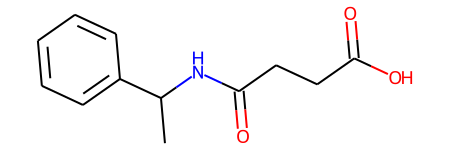

In [210]:
Chem.MolFromSmiles('CC(NC(=O)CCC(=O)O)c1ccccc1')

In [85]:
smile_to_formula('CC(NC(=O)CCC(=O)O)c1ccccc1')

'C12H15NO3'

In [21]:
instance = string_search(lcb_df, 'splash', 'splash10-000i-0920000000-2e4a7b4878c8d7900676').iloc[0]

In [19]:
pmz_candidates = quick_search_sorted(mega_mona, 'PrecursorMZ', row['precursor_mass']-0.005, row['precursor_mass']+0.005)

In [24]:
entropy_similarity = []
instance_msms = so.convert_lcb_to_string(instance['spectrum'])
for index, row in pmz_candidates.iterrows():
    entropy_similarity.append(so.entropy_identity(instance_msms, row['spectrum'], pmz=instance['precursor_mass'], mass_error=0.005))
pmz_candidates['entropy_similarity']=entropy_similarity

In [25]:
pmz_candidates.sort_values(by = 'entropy_similarity', ascending=False, inplace=True)
pmz_candidates

,library_idx,spectrum,Name,Ion_mode,Precursor_type,PrecursorMZ,SMILES,Comments,entropy_similarity
663771,169667,56.0492\t38.6\n58.0648\t5.4\n60.0805\t2.1\n72....,Metoprolol acid,P,[M+H]+,268.1543,CC(C)NCC(O)COc1ccc(CC(=O)O)cc1,NIST Mass Spectrometry Data Center,0.561434
663770,169666,56.0492\t8.6\n58.065\t1.4\n72.0804\t26.8\n74.0...,Metoprolol acid,P,[M+H]+,268.1543,CC(C)NCC(O)COc1ccc(CC(=O)O)cc1,NIST Mass Spectrometry Data Center,0.559715
663783,1326716,56.0494\t0.411184\n72.0808\t0.819205\n74.0601\...,Atenolol acid,P,[M+H]+,268.1543,NaN,"""SMILES=CC(C)NCC(O)COc1ccc(cc1)CC(=O)O"" ""cas=5...",0.556774
663750,1326722,56.0495\t0.680492\n72.0808\t0.994422\n74.0601\...,Atenolol acid,P,[M+H]+,268.1543,NaN,"""SMILES=CC(C)NCC(O)COc1ccc(cc1)CC(=O)O"" ""cas=5...",0.556481
663744,169668,56.0492\t149.0\n58.0648\t17.5\n60.0805\t4.1\n7...,Metoprolol acid,P,[M+H]+,268.1543,CC(C)NCC(O)COc1ccc(CC(=O)O)cc1,NIST Mass Spectrometry Data Center,0.555266
...,...,...,...,...,...,...,...,...,...
663741,483570,53.0384\t107.2\n54.0462\t14.3\n55.054\t140.9\n...,"2-(3-Hexyl-4-methyl-2,5-dioxopyrrol-1-yl)propa...",P,[M+H]+,268.1543,CCCCCCC1=C(C)C(=O)N(C(C)C(=O)O)C1=O,NIST Mass Spectrometry Data Center,0.000000
663740,1211872,51.023\t1.1\n55.0179\t3.4\n57.0699\t161.6\n57....,"1,4-Dibutoxy-2-nitrobenzene",P,[M+H]+,268.1543,CCCCOc1ccc(OCCCC)c([N+](=O)[O-])c1,NIST Mass Spectrometry Data Center,0.000000
663739,1211869,57.0701\t49.4\n58.0734\t1.4\n68.0133\t1.3\n71....,"1,4-Dibutoxy-2-nitrobenzene",P,[M+H]+,268.1543,CCCCOc1ccc(OCCCC)c([N+](=O)[O-])c1,NIST Mass Spectrometry Data Center,0.000000
663833,451752,200.0931\t649.6\n268.1557\t999.0\n269.1595\t5.1,"N-Cyclopentyl-1-methyl[1,2,4]triazolo[4,3-a]qu...",P,[M+H]+,268.1557,Cc1nnc2c(NC3CCCC3)nc3ccccc3n12,NIST Mass Spectrometry Data Center,0.000000


entropy similarity is  0.5614340192456636


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

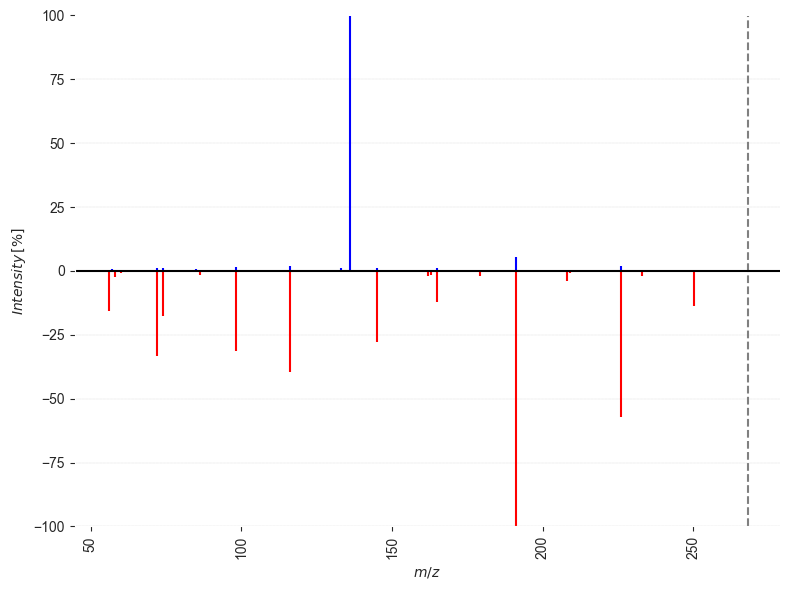

In [44]:
plotter.head_to_tail_plot(instance_msms, pmz_candidates.iloc[0]['spectrum'], pmz = instance['precursor_mass'])

In [27]:
master_formula = drf.prep_formula(smile_to_formula('CC(C)NCC(O)COc1ccc(CC(=O)O)cc1'), '[M+H]+')

In [ ]:
smile_to_formula()

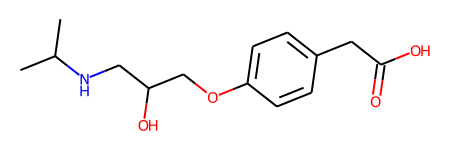

In [103]:
mol

In [102]:
find_longest_carbon_chain(mol)

2

In [105]:
# %%timeit
find_longest_element_chain(Chem.MolFromSmiles(sml))

7

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

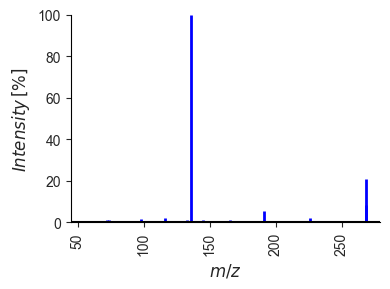

In [195]:
plotter.ms2_plot(instance_msms)

In [30]:
element_dict, element_count, element_mass, all_possible_mass, all_possible_candidate_formula = drf.get_all_subsets(master_formula)

In [93]:
nl_mass = 268.1543217-136.0619
left_idx, right_idx =all_possible_mass.searchsorted([nl_mass-0.01, nl_mass+0.01+1E-9])

In [98]:
132.102454-132.093900

0.008554000000003725

In [166]:
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit import Chem

In [115]:
parsed_formula

{'C': 6.0, 'H': 12.0, 'O': 1.0}

In [ ]:
from toolsets.

In [188]:
parsed_formula = chemparse.parse_formula(formula)

In [172]:
check_senior_shorten('CH4')

max valence:  4
sum valence:  8.0
total # elements: 5.0


False

In [187]:
drf.candidates_to_formulas(all_possible_candidate_formula[left_idx:right_idx], element_dict)

['H2O']

In [18]:
# reference_db = pd.read_csv('/Users/fanzhoukong/Documents/GitHub/Libgen_2.0/db/formulaDB_sorted.csv')

In [6]:
from molmass import Formula

In [40]:
# m_plus_one = np.zeros(len(reference_db))
# for index, row in tqdm(reference_db.iterrows(), total = len(reference_db)):
#     spec = Formula(row['formstr']).spectrum()
#     step = 0
#     mono_mass = Formula('BH').mass
#     compositie = np.zeros(2)
#     for k in spec.keys():
#         if step >1:
#             break
#         if k<mono_mass:
#             continue
#         compositie[step]=spec[k][1]
#         step = step+1
#     m_plus_one[index]=compositie[1]/compositie[0]

100%|██████████| 3514089/3514089 [26:50<00:00, 2182.49it/s]


# below are masswiki data

In [202]:
master_validation = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_validation/QE'

In [69]:
import ast

In [61]:
from toolsets.file_io import get_file_list

In [203]:
file_list = get_file_list(master_validation, '.mzML', with_tail=False)

In [204]:
import toolsets.T_rex as trx

In [205]:
for f in file_list:
    feature_temp = trx.find_feature(f, master_validation, intensity_threshold=30000, n_neighbor=2)
    feature_temp[0].to_csv(os.path.join(master_validation, f+'.csv'), index = False)

100%|██████████| 251176/251176 [00:13<00:00, 17969.98it/s]


# indoline

In [206]:
import toolsets.chem_utils as cu

In [456]:
compound_mw = string_search(mass_wiki_orb, 'name', 'indoline', reset_index=False)
compound_mw
row = compound_mw.iloc[0]

In [457]:
ms1, ms2 = rds.read_mzml('Indio', master_validation)
mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)
feature_temp = trx.find_feature('Indio', master_validation, intensity_threshold=30000, n_neighbor=2)

100%|██████████| 245238/245238 [00:13<00:00, 18549.55it/s]


In [458]:
search_feature(feature_temp[0], 103.054264)

,precursor_mz,eic_center,eic_offset,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,reci_snr,pmz_offset,msms,ms2_scan_idx
51,103.054276,103.054237,0.005195,0.187798,0.164769,0.230219,3024395.25,14.0,"[34, 39, 49]",0.112922,0.000039,50.01933288574219\t2128.84716796875\n51.023353...,119.0


In [459]:
feature_row = search_feature(feature_temp[0], 103.054264).iloc[0]

In [465]:
row

eis                                                             0.136651
scan                                                              6212.0
rt                                                            100.411809
precursor_mz                                                  103.054283
charge                                                                 1
peak                   103.0542984008789\t18139964\n95.04930114746094...
username                                                    Oliver Fiehn
name                                                            indoline
comments               The compound matched with the NIST23 library, ...
smiles                                                  C1CNC2=CC=CC=C21
adduct                                                        [M+H-NH3]+
method                        5m hilic | orbitrap | beh amide | positive
version                                                          LCB2023
splash                     splash10-0udi-5900000000

In [463]:
cu.everything_to_image(row['smiles'], savepath=os.path.join(master_validation, 'indo.png'))

entropy similarity is  0.47482669697001223


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

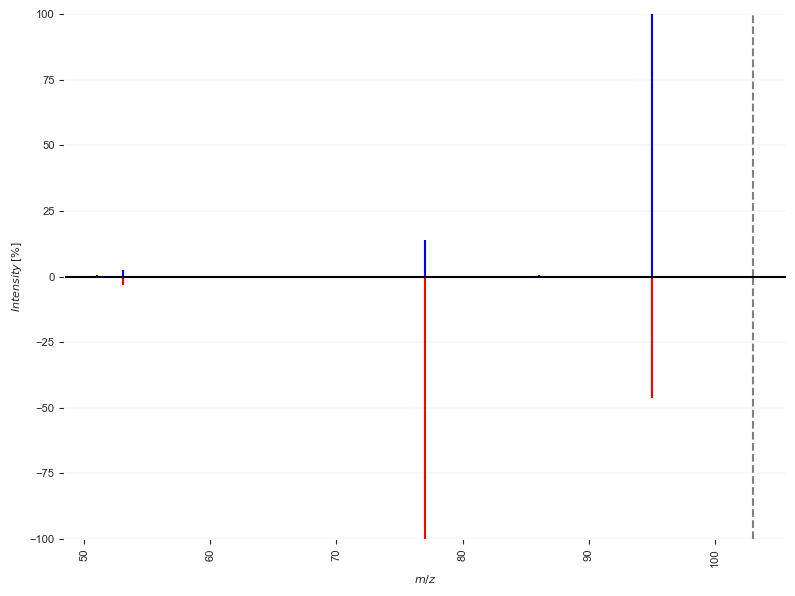

In [462]:
plotter.head_to_tail_plot(row['peak'],row['library_peaks'], pmz = row['precursor_mz'], savepath=os.path.join(master_validation, 'indo_raw_lib.png'))

entropy similarity is  0.7059207262058349


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

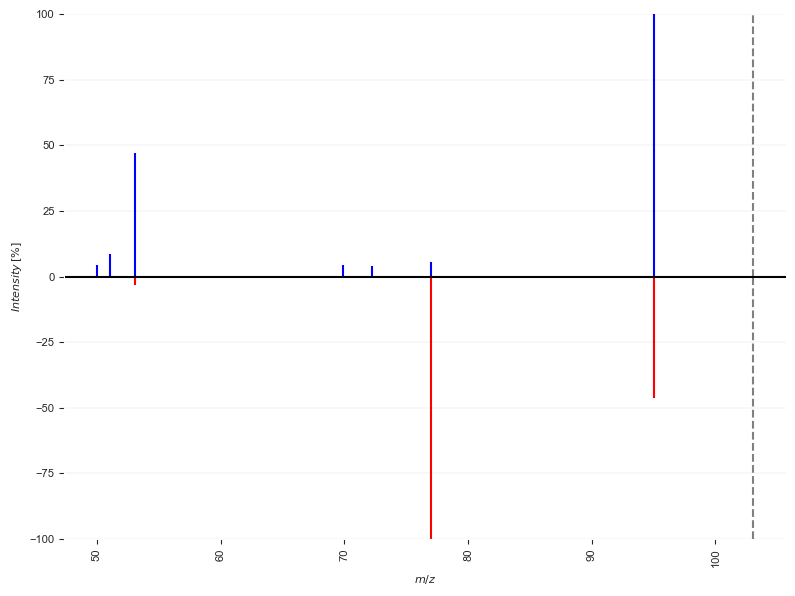

In [466]:
plotter.head_to_tail_plot(feature_row['msms'],row['library_peaks'], pmz = row['precursor_mz'], savepath=os.path.join(master_validation, 'indo_ref_lib.png'))

In [337]:
search_feature(feature_temp[0], 120.0807)

,precursor_mz,eic_center,eic_offset,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,reci_snr,pmz_offset,msms,ms2_scan_idx
0,120.080702,120.080856,0.004,0.192054,0.154261,3.427245,1.205299e+09,707.0,"[32, 40, 740]",0.000082,0.000154,51.02348709106445\t673655.6875\n53.03888320922...,122.0
1,120.080752,120.080856,0.004,0.018283,0.008795,0.037101,3.467227e+04,5.0,"[0, 2, 6]",0.000000,0.000104,NaN,NaN


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

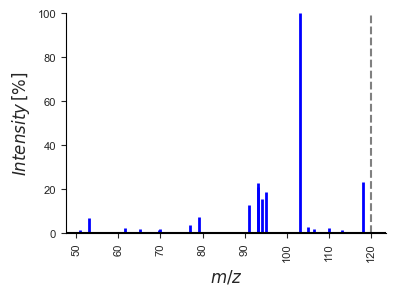

In [338]:
plotter.ms2_plot(search_feature(feature_temp[0], 120.0807).iloc[0]['msms'], pmz1=120.0807)

In [305]:
feature_temp.iloc[0]['msms']

'51.02348709106445\t673655.6875\n53.038883209228516\t3155690.75\n61.636329650878906\t1052105.125\n65.03895568847656\t889271.6875\n69.57878875732422\t666994.75\n69.89153289794922\t774832.5\n77.03895568847656\t1676149.125\n79.05432891845703\t3208819.75\n91.05414581298828\t5698921.5\n93.05738067626953\t9359204.0\n93.07003784179688\t10225627.0\n94.06520080566406\t6915414.0\n95.04914855957031\t8435889.0\n103.05427551269531\t44885208.0\n105.0450439453125\t1197976.375\n106.35507202148438\t734416.5625\n110.05988311767578\t1013566.3125\n113.15045166015625\t651482.4375\n118.06507873535156\t10420505.0\n119.07328033447266\t4207038.5\n120.08086395263672\t476780096.0'

In [287]:
cu.calculate_precursormz('C1CNC2=CC=CC=C21', '[M+H]+', if_smiles=True)-cu.calculate_precursormz('C6H5HO', '[M+H]+')

25.03163448155

In [284]:
feature_temp.iloc[0]['msms']

'51.02348709106445\t673655.6875\n53.038883209228516\t3155690.75\n61.636329650878906\t1052105.125\n65.03895568847656\t889271.6875\n69.57878875732422\t666994.75\n69.89153289794922\t774832.5\n77.03895568847656\t1676149.125\n79.05432891845703\t3208819.75\n91.05414581298828\t5698921.5\n93.05738067626953\t9359204.0\n93.07003784179688\t10225627.0\n94.06520080566406\t6915414.0\n95.04914855957031\t8435889.0\n103.05427551269531\t44885208.0\n105.0450439453125\t1197976.375\n106.35507202148438\t734416.5625\n110.05988311767578\t1013566.3125\n113.15045166015625\t651482.4375\n118.06507873535156\t10420505.0\n119.07328033447266\t4207038.5\n120.08086395263672\t476780096.0'

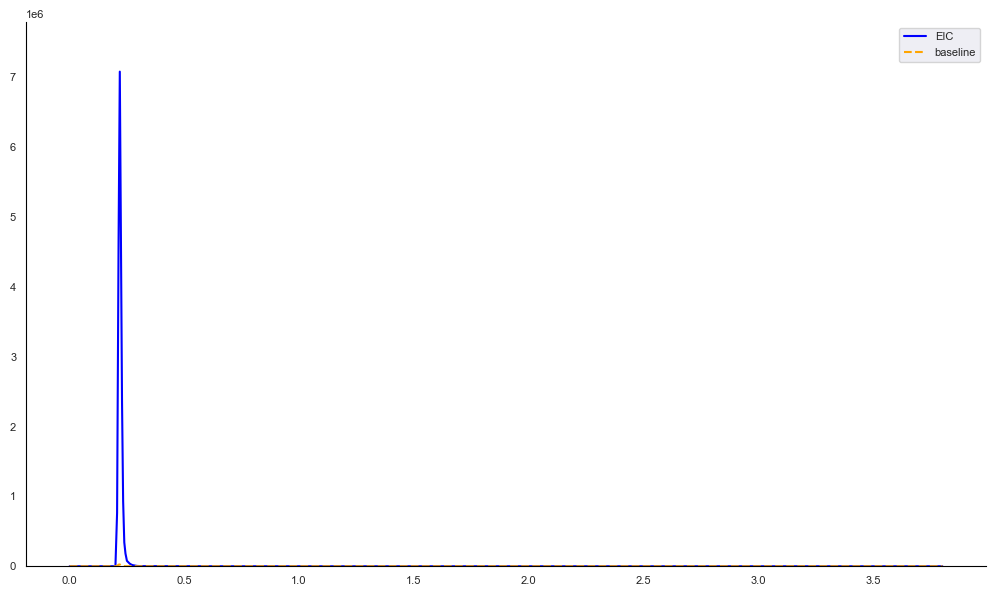

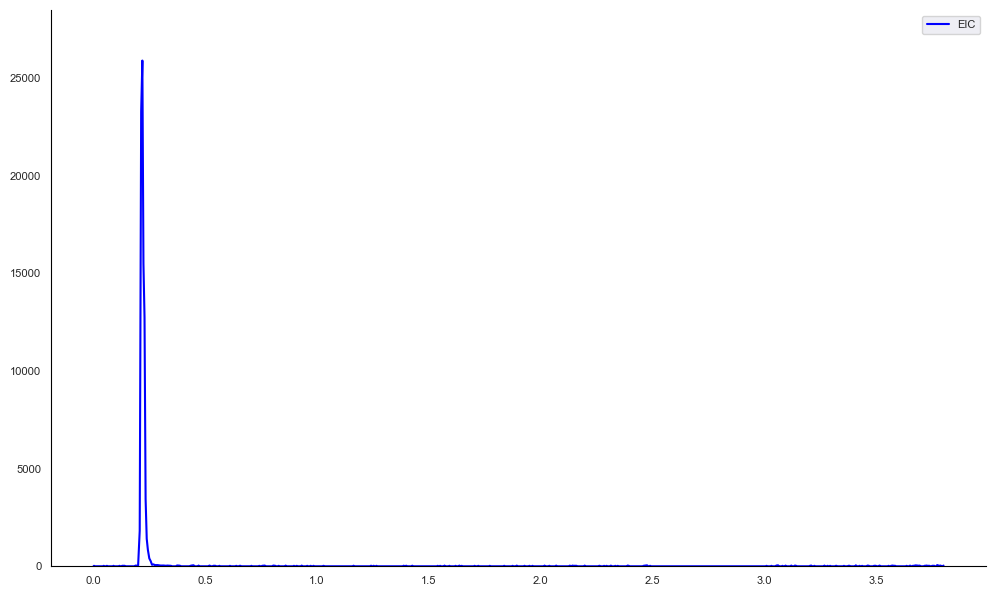

In [97]:
# intensity_list_h = trx.flash_eic(H_adduct, mass_sorted, intensity_sorted, index_sorted)
# intensity_list_nh2 = trx.flash_eic(Nh2_adduct, mass_sorted, intensity_sorted, index_sorted)
# rds.EIC(rt_list, intensity_list_h, base_line_series=intensity_list_nh2)
# rds.EIC(rt_list, intensity_list_nh2)

indoline
entropy similarity is  0.47482669697001223
entropy similarity is  0.6517891797293509


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

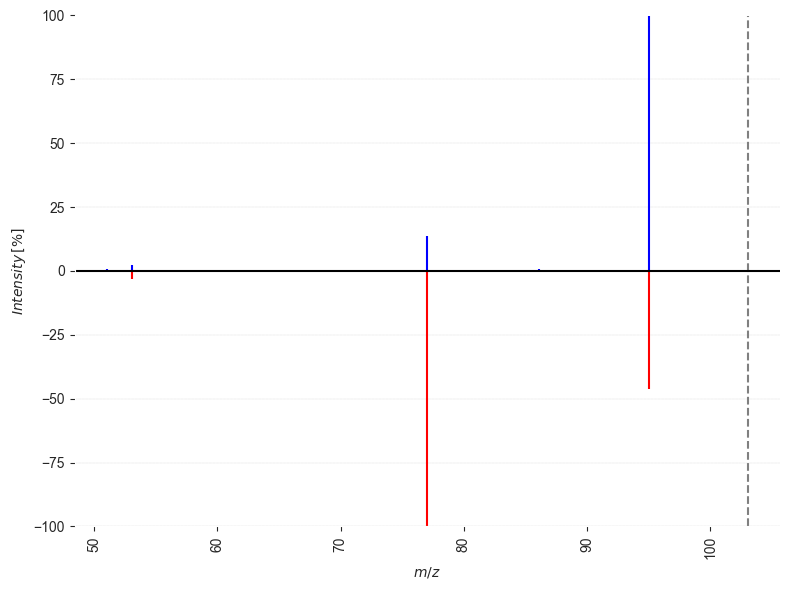

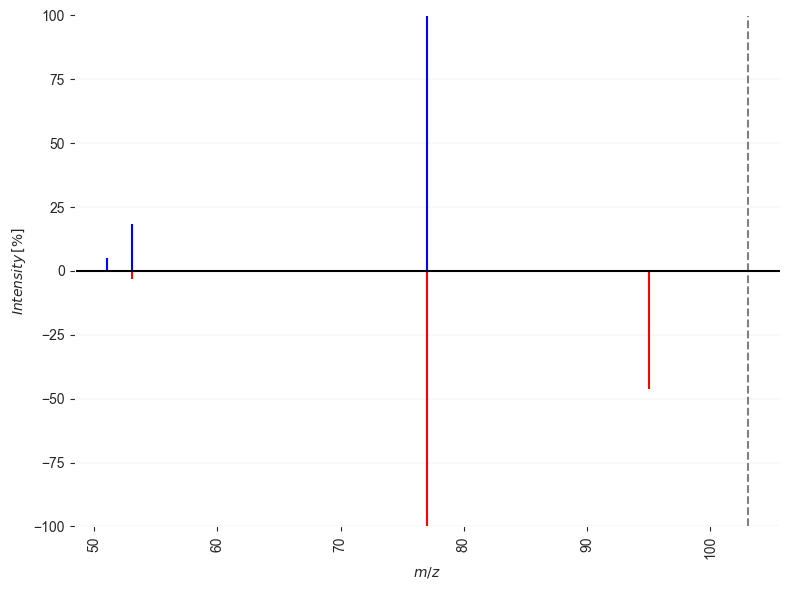

In [76]:
row = mass_wiki_orb.loc[150]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

# cytosine

In [469]:
compound_mw = string_search(mass_wiki_orb, 'name', 'cytosine', reset_index=False)


In [473]:
81/60

1.35

In [470]:
row = compound_mw.iloc[1]
row

eis                                                             0.589702
scan                                                              2076.0
rt                                                             81.857716
precursor_mz                                                  112.050581
charge                                                                 1
peak                   112.05049896240234\t642119616\n70.066703796386...
username                                                    Oliver Fiehn
name                                                            cytosine
comments               The compound matched with the GNPS library, id...
smiles                                                 C1=C(NC(=O)N=C1)N
adduct                                                            [M+H]+
method                        5m hilic | orbitrap | beh amide | positive
version                                                          LCB2023
splash                     splash10-03di-3900000000

In [386]:
cu.everything_to_image(row['smiles'],savepath=os.path.join(master_validation, row['name']+'.png'))

In [467]:

feature_temp = pd.read_csv(os.path.join(master_validation, 'Cyto.csv'))
ms1, ms2= rds.read_mzml('Cyto', master_validation)
mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)

In [472]:
search_feature(feature_temp, row['precursor_mz'])
feature_row = search_feature(feature_temp, row['precursor_mz']).iloc[0]
feature_row

precursor_mz                                             112.050565
eic_center                                               112.050591
eic_offset                                                    0.004
rt_apex                                                     1.31952
rt_start                                                   1.256339
rt_end                                                     1.902056
ms1_intensity                                            70439416.0
n_scnas                                                       135.0
ms1_scan_range                                      [276, 290, 412]
reci_snr                                                   0.003372
pmz_offset                                                 0.000026
msms              50.61815643310547\t29082.419921875\n52.0186195...
ms2_scan_idx                                                  871.0
Name: 1, dtype: object

entropy similarity is  0.8672417430583305


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

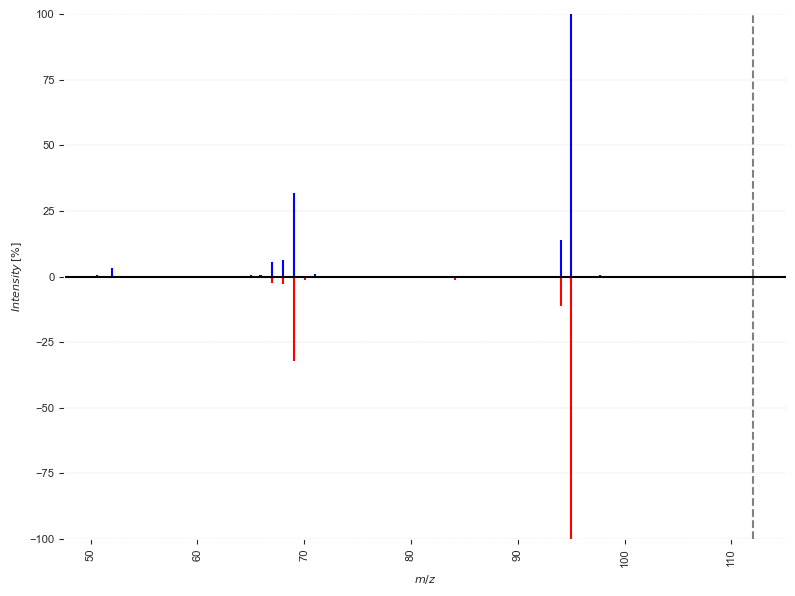

In [391]:
plotter.head_to_tail_plot(feature_row['msms'], row['library_peaks'], pmz=row['precursor_mz'], savepath=(os.path.join(master_validation, 'cyto_ref_lib.png')))

entropy similarity is  0.8956877610644498


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

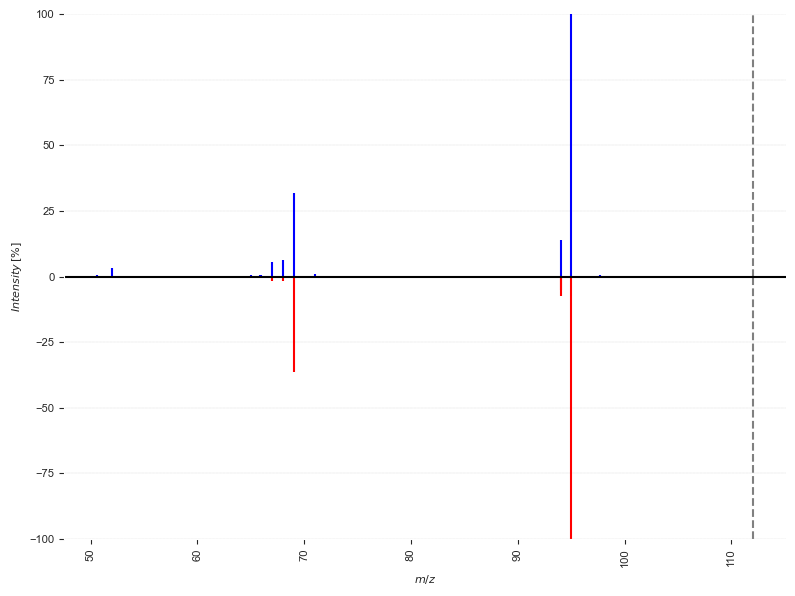

In [400]:
plotter.head_to_tail_plot(feature_row['msms'], row['peaks_denoised'], pmz=row['precursor_mz'],
                          # savepath=(os.path.join(master_validation, 'cyto_raw_lib.png'))
                          )

In [397]:
row

eis                                                             0.589702
scan                                                              2076.0
rt                                                             81.857716
precursor_mz                                                  112.050581
charge                                                                 1
peak                   112.05049896240234\t642119616\n70.066703796386...
username                                                    Oliver Fiehn
name                                                            cytosine
comments               The compound matched with the GNPS library, id...
smiles                                                 C1=C(NC(=O)N=C1)N
adduct                                                            [M+H]+
method                        5m hilic | orbitrap | beh amide | positive
version                                                          LCB2023
splash                     splash10-03di-3900000000

# melamine

In [401]:
compound_mw = string_search(mass_wiki_orb, 'name', 'melamine', reset_index=False)



In [402]:
compound_mw

,eis,scan,rt,precursor_mz,charge,peak,username,name,comments,smiles,adduct,method,version,splash,library_peaks,peaks_denoised,simialrity_raw,similarity_denoised,similarity_offset
28,0.841643,2287.0,63.848983,127.072693,1,127.07250213623047\t730741760\n85.050796508789...,Oliver Fiehn,melamine,"The compound matched with the GNPS library, id...",C1(=NC(=NC(=N1)N)N)N,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-004i-3900000000-b71ab40174075d95f093,85.05079650878906\t0.8885874152183533\n68.0242...,60.05569839477539\t5819860.0\n61.0558013916015...,0.511579,0.860880,0.349301
29,0.994720,4458.0,71.704887,127.072681,1,127.07270050048828\t16150419456\n85.0512008666...,Oliver Fiehn,melamine,"The compound matched with the GNPS library, id...",C1(=NC(=NC(=N1)N)N)N,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-004r-6900000000-b8d34e66f1591c1c5028,85.0509033203125\t0.8313165903091431\n68.02429...,43.02899932861328\t16291051.0\n43.031299591064...,0.574186,0.913238,0.339052
221,0.968778,5914.0,92.600687,127.072628,1,127.07260131835938\t3103780\n85.05110168457031...,Oliver Fiehn,melamine,"The compound matched with the GNPS library, id...",C1(=NC(=NC(=N1)N)N)N,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-004i-5900000000-38dd7e039090e7b186e7,85.0509033203125\t0.8313165903091431\n68.02429...,60.055999755859375\t97071.6015625\n68.02480316...,0.771409,0.913089,0.141680


In [403]:
row = compound_mw.iloc[0]

In [404]:
feature_temp = pd.read_csv(os.path.join(master_validation, 'Melam.csv'))
ms1, ms2= rds.read_mzml('Melam', master_validation)
mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)
search_feature(feature_temp, row['precursor_mz'])

,precursor_mz,eic_center,eic_offset,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,reci_snr,pmz_offset,msms,ms2_scan_idx
13,127.072731,127.075287,0.004,1.049808,0.960278,1.602559,16579750.0,138.0,"[214, 234, 353]",0.004652,0.002556,52.81758117675781\t10739.0537109375\n56.748859...,704.0


In [405]:
feature_row =search_feature(feature_temp, row['precursor_mz']).iloc[0]

In [406]:
cu.everything_to_image(row['smiles'], savepath=os.path.join(master_validation, 'mela.png'))

entropy similarity is  0.5115791922705049


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

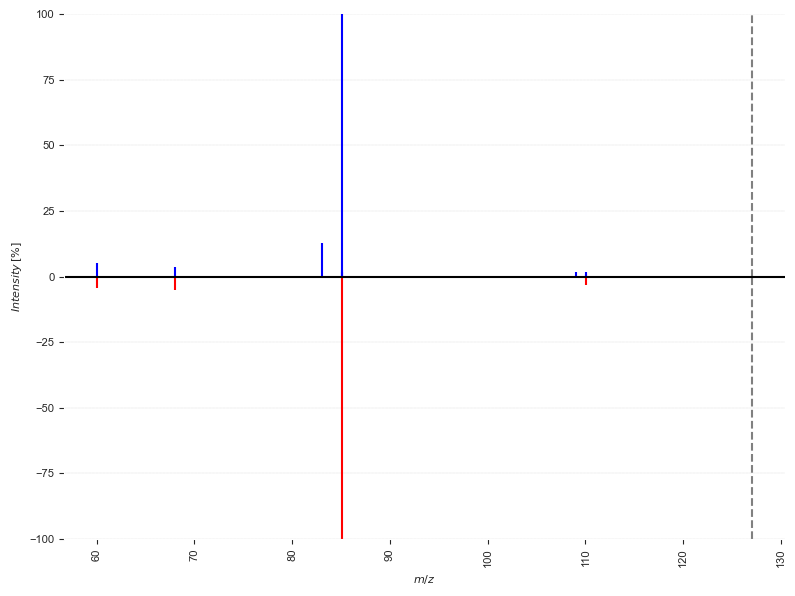

In [407]:
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'], savepath=os.path.join(master_validation, 'mela_raw_lib.png'))

entropy similarity is  0.8608804722466779


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

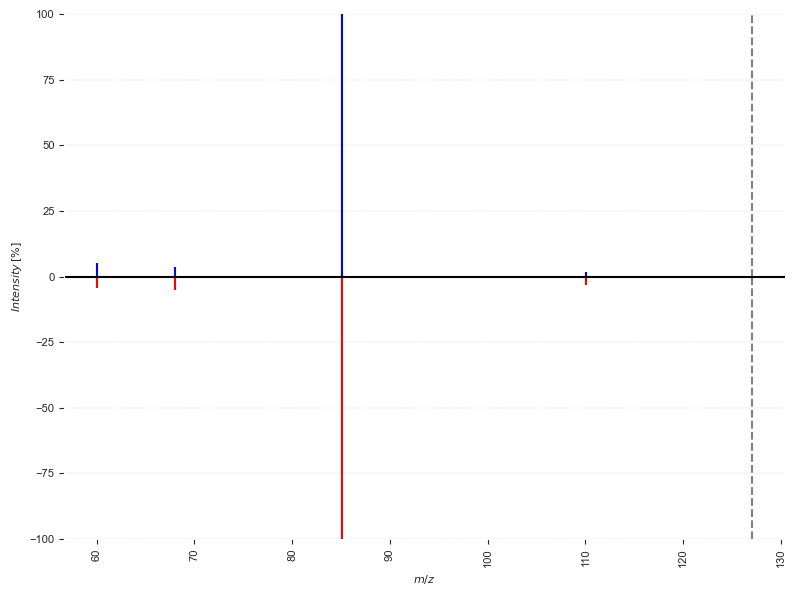

In [408]:
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'], savepath=os.path.join(master_validation, 'mela_denoised_lib.png'))

entropy similarity is  0.728253060813637


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

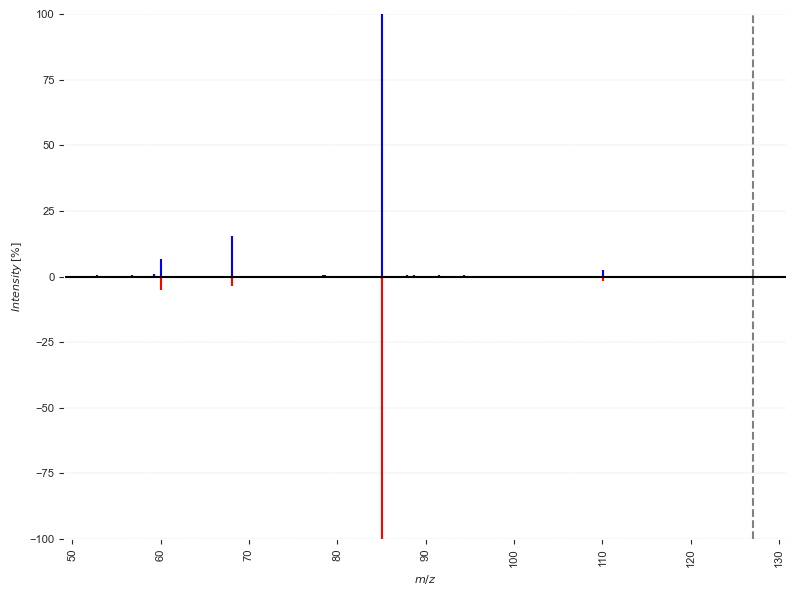

In [414]:
plotter.head_to_tail_plot(feature_row['msms'], row['peaks_denoised'], pmz=row['precursor_mz'],
                          savepath=os.path.join(master_validation, 'mela_ref_denoised.png')
                          )

# Piperdine

In [479]:
compound_mw = string_search(mass_wiki_orb, 'name', 'piperidine', reset_index=False)

In [480]:
compound_mw

,eis,scan,rt,precursor_mz,charge,peak,username,name,comments,smiles,adduct,method,version,splash,library_peaks,peaks_denoised,simialrity_raw,similarity_denoised,similarity_offset
0,0.958380,2337.0,153.713117,86.096519,1,86.09629821777344\t1008191680\n69.069503784179...,Oliver Fiehn,piperidine,"The compound matched with the GNPS library, id...",C1CCNCC1,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-000i-9000000000-e59d5cb98a6b1634b5e1,69.0698013305664\t0.9687405824661255\n67.05419...,64.02660369873047\t15434.26953125\n67.05429840...,0.296435,0.901373,0.604938
1,0.973955,3010.0,130.561175,86.096473,1,86.09639739990234\t7315721216\n69.069099426269...,Oliver Fiehn,piperidine,"The compound matched with the GNPS library, id...",C1CCNCC1,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-000i-9000000000-ef522aca37b872417fa7,69.0698013305664\t0.9687405824661255\n67.05419...,61.085201263427734\t3086.8798828125\n62.008499...,0.232426,0.820046,0.587620
2,0.962826,3130.0,137.769606,86.096469,1,86.09629821777344\t3805713152\n69.069503784179...,Oliver Fiehn,piperidine,The compound matched with the MassBank.us libr...,C1CCNCC1,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-000i-9000000000-fb2769568af3a01b5464,69.0698013305664\t0.9687405824661255\n67.05419...,61.008399963378906\t6388.5400390625\n63.032199...,0.242445,0.822488,0.580043
3,0.947132,3929.0,147.552411,86.096547,1,86.09629821777344\t930484736\n69.0695037841796...,Oliver Fiehn,piperidine,"The compound matched with the GNPS library, id...",C1CCNCC1,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-000i-9000000000-3dd86298785a33cc6d04,69.07099914550781\t1,61.000099182128906\t6572.8798828125\n67.047698...,0.285226,0.790331,0.505105
5,0.903675,2909.0,94.553243,86.096472,1,86.09639739990234\t248064688\n69.0697021484375...,Oliver Fiehn,piperidine,"The compound matched with the GNPS library, id...",C1CCNCC1,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-000i-9000000000-caa1fe238fe931d05994,69.07099914550781\t1,61.000701904296875\t3371.47998046875\n64.02410...,0.261451,0.751319,0.489868
7,0.963218,147.0,66.766318,86.096517,1,86.09649658203125\t63081664512\n69.06929779052...,Oliver Fiehn,piperidine,"The compound matched with the GNPS library, id...",C1CCNCC1,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-000i-9000000000-3023dbbdfa71d3d82ccc,69.0698013305664\t0.9687405824661255\n67.05419...,41.03860092163086\t555572.5625\n56.04980087280...,0.224807,0.691415,0.466608
24,0.773852,3166.0,173.365668,86.096512,1,86.09639739990234\t10643239\n86.06009674072266...,Oliver Fiehn,piperidine,"The compound matched with the GNPS library, id...",C1CCNCC1,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-000i-9000000000-a188ad1e283fdfdda2c1,69.07099914550781\t1,69.0697021484375\t682600.4375\n69.069999694824...,0.480294,0.838280,0.357986


In [481]:
row = compound_mw.loc[24]

In [427]:
cu.everything_to_image(row['smiles'], savepath=os.path.join(master_validation, 'piper.png'))

entropy similarity is  0.4802940894462996


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

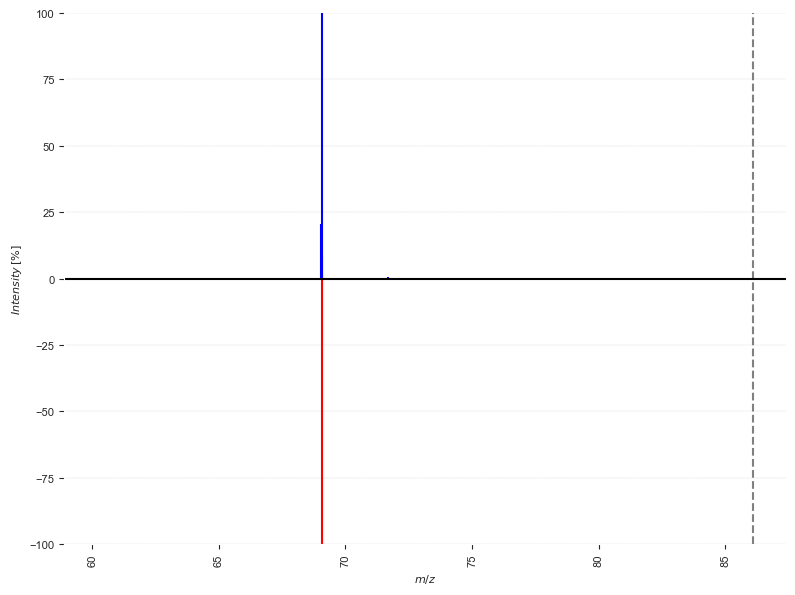

In [482]:
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz = row['precursor_mz'],
                          # savepath=os.path.join(master_validation, 'pip_raw_lib.png')
                          )

In [477]:
feature_temp = pd.read_csv(os.path.join(master_validation, 'Piper.csv'))
ms1, ms2= rds.read_mzml('Piper', master_validation)
mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)
search_feature(feature_temp, row['precursor_mz'])

,precursor_mz,eic_center,eic_offset,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,reci_snr,pmz_offset,msms,ms2_scan_idx


In [483]:
master_qtof = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_validation/TTof'

In [484]:
ms1, ms2= rds.read_mzml('Indoline-pos.mzML', master_qtof)

In [485]:
search_feature(ms2,  103.054264)

,scan_idx,cycle,ms_level,precursor_mz,polarity,rt,peaks,isolation_window,ms1_pmz,ms1_rt,ms1_precursor_intensity,peak_purity,mz_offset,mix,base_name
11,82,70,2,103.052427,+,0.221350,"[[50.01576658152738, 327.0], [51.0241391314998...","(102.552427012741, 103.552427012741)",103.051622,0.220483,25890.0,1.000000,0.000805,Indoline-pos,Indoline-pos.mzML
18,91,72,2,103.052813,+,0.231683,"[[43.038940099243014, 19.0], [50.0177514492393...","(102.552812587469, 103.552812587469)",103.053046,0.230150,12740.0,1.000000,0.000234,Indoline-pos,Indoline-pos.mzML
7,77,69,2,103.053029,+,0.216850,"[[43.02973451499069, 33.0], [49.00959834024856...","(102.553029385885, 103.553029385885)",103.053046,0.215150,23283.0,0.993556,0.000017,Indoline-pos,Indoline-pos.mzML


In [488]:
row['peaks']

array([[ 50.01576658, 327.        ],
       [ 51.02413913, 867.        ],
       [ 51.56887434,  56.        ],
       [ 51.69289774,  56.        ],
       [ 52.0203065 ,  56.        ],
       [ 53.03632343,  56.        ],
       [ 63.02418154,  66.        ],
       [ 65.97217767,  56.        ],
       [ 74.02159154, 131.        ],
       [ 75.02705999,  56.        ],
       [ 76.03074589,  56.        ],
       [ 76.80971509,  56.        ],
       [ 77.04602762, 569.        ],
       [ 77.20253796,  56.        ],
       [ 77.75095606,  56.        ],
       [ 78.12012702,  56.        ],
       [ 78.23675833,  56.        ],
       [ 87.02378614,  56.        ],
       [ 95.06364073,  56.        ],
       [102.05183548,  66.        ],
       [103.05511603, 197.        ]])

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

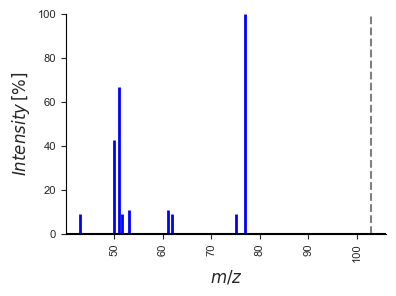

In [489]:
row = search_feature(ms2,  103.054264).iloc[1]
plotter.ms2_plot(so.convert_nist_to_string(row['peaks']), pmz1 = row['precursor_mz'], savepath=os.path.join(master_validation, 'indoline_tof.png'))

In [428]:
feature_row = search_feature(feature_temp, row['precursor_mz']).iloc[0]

entropy similarity is  0.83827960823784


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

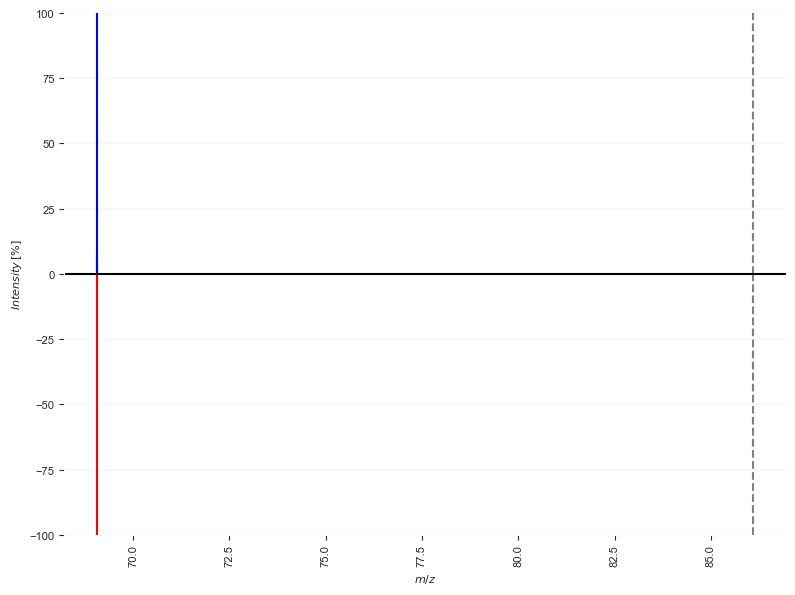

In [429]:
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz = row['precursor_mz'],
                          savepath=os.path.join(master_validation, 'pip_denoised_lib.png')
                          )

entropy similarity is  0.7807054502121119


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

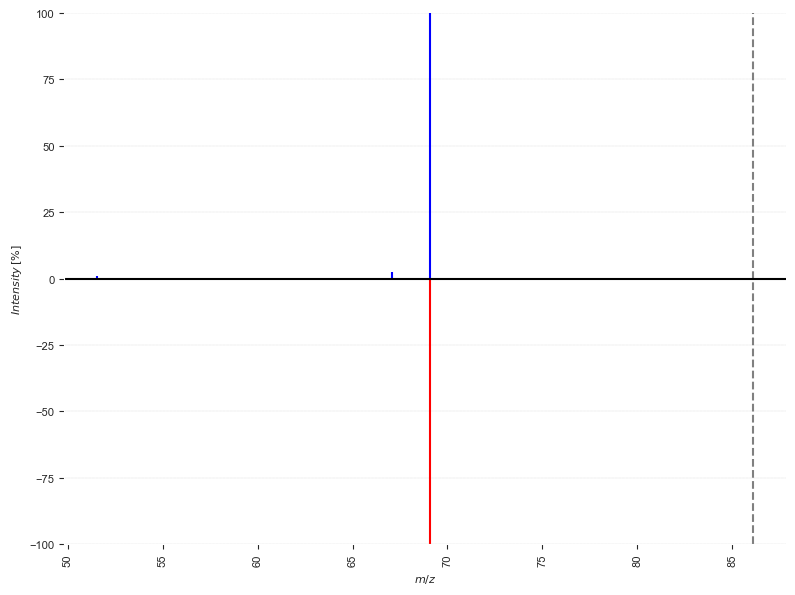

In [430]:
plotter.head_to_tail_plot(feature_row['msms'], row['library_peaks'], pmz = row['precursor_mz'],
                          savepath=os.path.join(master_validation, 'pip_ref_denoised.png')
                          )

entropy similarity is  0.40006135028015777


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

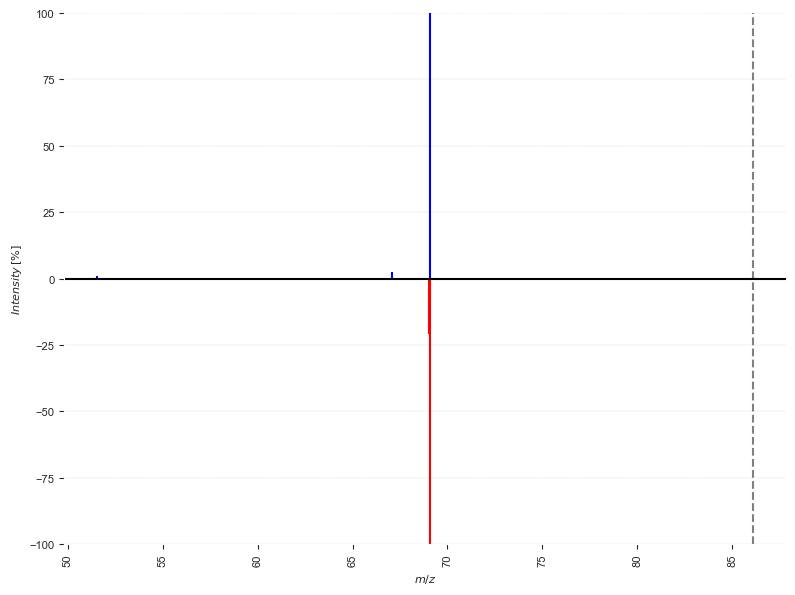

In [266]:
plotter.head_to_tail_plot(feature_row['msms'], row['peak'], pmz = row['precursor_mz'])

# panto acid

In [431]:
compound_mw = string_search(mass_wiki_orb, 'name', 'pantothenic acid', reset_index=False)
compound_mw

,eis,scan,rt,precursor_mz,charge,peak,username,name,comments,smiles,adduct,method,version,splash,library_peaks,peaks_denoised,simialrity_raw,similarity_denoised,similarity_offset
169,0.614260,4427.0,54.469269,242.099731,1,242.09959411621094\t602179.375\n112.0370025634...,Oliver Fiehn,pantothenic acid,"The compound matched with the GNPS library, id...",CC(C)(CO)C(C(=O)NCCC(=O)O)O,[M+Na]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-0006-0190000000-20f20830e805d4db180c,224.08900451660156\t0.32604336738586426\n112.0...,86.09619903564453\t4254.14013671875\n112.03700...,0.607719,0.773533,0.165814
170,0.614260,4427.0,54.469269,242.099731,1,242.09959411621094\t602179.375\n112.0370025634...,Oliver Fiehn,pantothenic acid,"The compound matched with the GNPS library, id...",CC(C)(CO)C(C(=O)NCCC(=O)O)O,[M+Na]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-0006-0190000000-20f20830e805d4db180c,224.08900451660156\t0.32604336738586426\n112.0...,86.09619903564453\t4254.14013671875\n112.03700...,0.607719,0.773533,0.165814
785,0.937138,645.0,42.795153,220.118011,1,90.05500030517578\t933772.625\n73.028396606445...,Oliver Fiehn,pantothenic acid,"The compound matched with the GNPS library, id...",CC(C)(CO)C(C(=O)NCCC(=O)O)O,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-00di-9110000000-df1df707d839c4fe10dd,90.05549621582031\t0.32352346181869507\n202.10...,50.02190017700195\t1229.31005859375\n51.076301...,0.857501,0.888277,0.030776
1166,0.989317,4312.0,61.430569,220.117979,1,90.05490112304688\t1079567.125\n220.1177062988...,Oliver Fiehn,pantothenic acid,"The compound matched with the NIST23 library, ...",CC(C)(CO)C(C(=O)NCCC(=O)O)O,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-0006-9560000000-c2bb652ecbb4691c12e5,90.05480194091797\t0.4041098356246948\n202.107...,63.02090072631836\t703.969970703125\n67.054199...,0.962345,0.973244,0.010899
1284,0.992627,2186.0,55.133490,220.117942,1,90.05490112304688\t50574308\n220.1177978515625...,Oliver Fiehn,pantothenic acid,"The compound matched with the NIST23 library, ...",CC(C)(CO)C(C(=O)NCCC(=O)O)O,[M+H]+,5m hilic | orbitrap | beh amide | positive,LCB2023,splash10-006x-9550000000-465ae0904fdfa2fefb4f,90.05480194091797\t0.4041098356246948\n202.107...,60.03860092163086\t1251.56005859375\n60.109500...,0.930189,0.936571,0.006382


In [437]:
row = compound_mw.iloc[0]
row

eis                                                              0.61426
scan                                                              4427.0
rt                                                             54.469269
precursor_mz                                                  242.099731
charge                                                                 1
peak                   242.09959411621094\t602179.375\n112.0370025634...
username                                                    Oliver Fiehn
name                                                    pantothenic acid
comments               The compound matched with the GNPS library, id...
smiles                                       CC(C)(CO)C(C(=O)NCCC(=O)O)O
adduct                                                           [M+Na]+
method                        5m hilic | orbitrap | beh amide | positive
version                                                          LCB2023
splash                     splash10-0006-0190000000

In [438]:
cu.everything_to_image(row['smiles'], os.path.join(master_validation, 'panto.png'))

In [433]:
feature_temp = trx.find_feature('Panto', master_validation, n_neighbor=2, intensity_threshold=30000)

100%|██████████| 264033/264033 [00:16<00:00, 16202.94it/s]


In [434]:

# feature_temp = pd.read_csv(os.path.join(master_validation, 'Panto.csv'))
ms1, ms2= rds.read_mzml('Panto', master_validation)
mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)
search_feature(feature_temp[0], row['precursor_mz'])

,precursor_mz,eic_center,eic_offset,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,reci_snr,pmz_offset,msms,ms2_scan_idx
579,242.100036,242.100067,0.004,0.806666,0.765875,0.870337,614633.25,24.0,"[174, 183, 199]",0.041016,0.000031,50.47753143310547\t2061.98193359375\n149.76564...,566.0


In [439]:
search_feature(ms2, 242.100036)

,scan_idx,cycle,ms_level,precursor_mz,polarity,rt,peaks,isolation_window,ms1_pmz,ms1_rt,ms1_precursor_intensity,peak_purity,mz_offset,mix,base_name
377,566,188,2,242.10025,+,0.829188,"[[50.47753143310547, 2061.98193359375], [149.7...","(241.600250244141, 242.600250244141)",242.100067,0.825094,218898.984375,0.718771,0.000183,Panto,Panto.mzML


In [449]:
feature_row = search_feature(feature_temp[0], 242.100036).iloc[0]

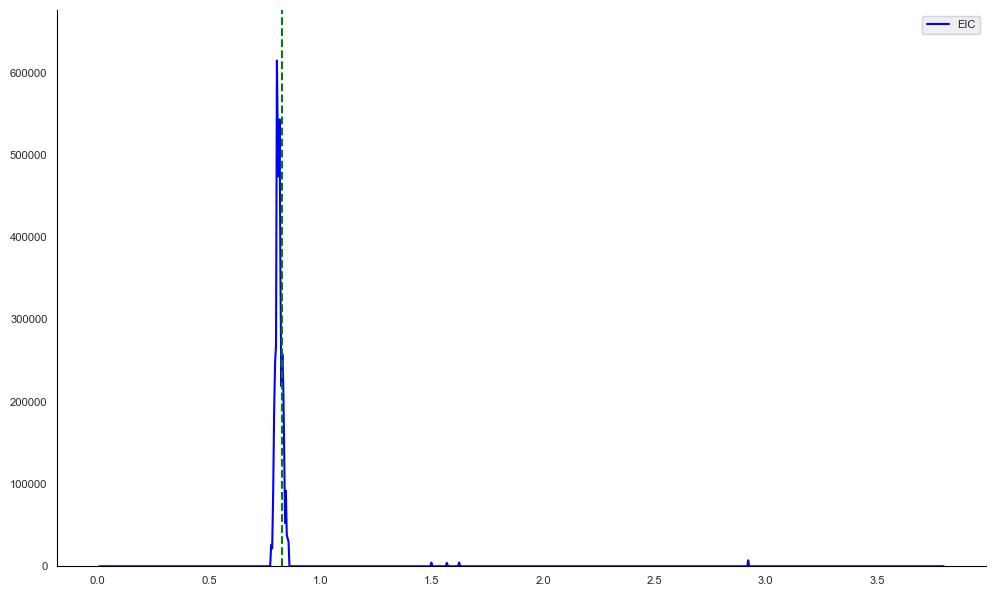

In [436]:
intensity_list = trx.flash_eic(row['precursor_mz'], mass_sorted, intensity_sorted, index_sorted)
rds.EIC(rt_list, intensity_list, vlines_location_2=[0.829188], savepath = os.path.join(master_validation, 'panto_eic.png'))

In [355]:
feature_row = search_feature(feature_temp[0], row['precursor_mz']).iloc[0]

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

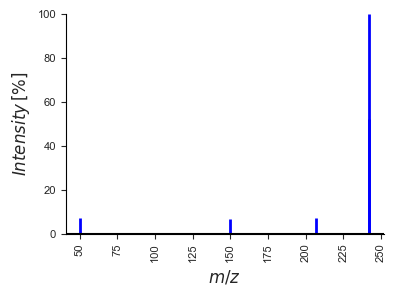

In [362]:
plotter.ms2_plot(feature_row['msms'])

entropy similarity is  0


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

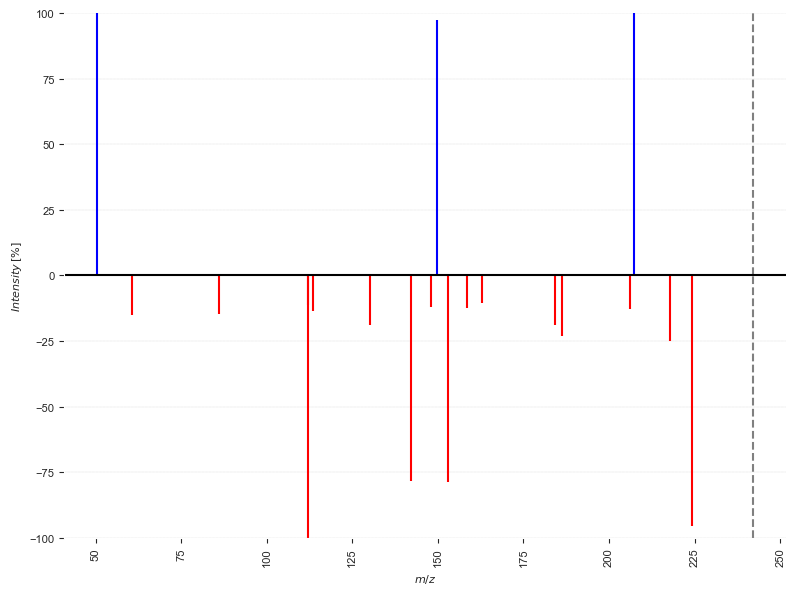

In [366]:
plotter.head_to_tail_plot(feature_row['msms'], row['peak'], pmz = row['precursor_mz'])

entropy similarity is  0.6077192660706843


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

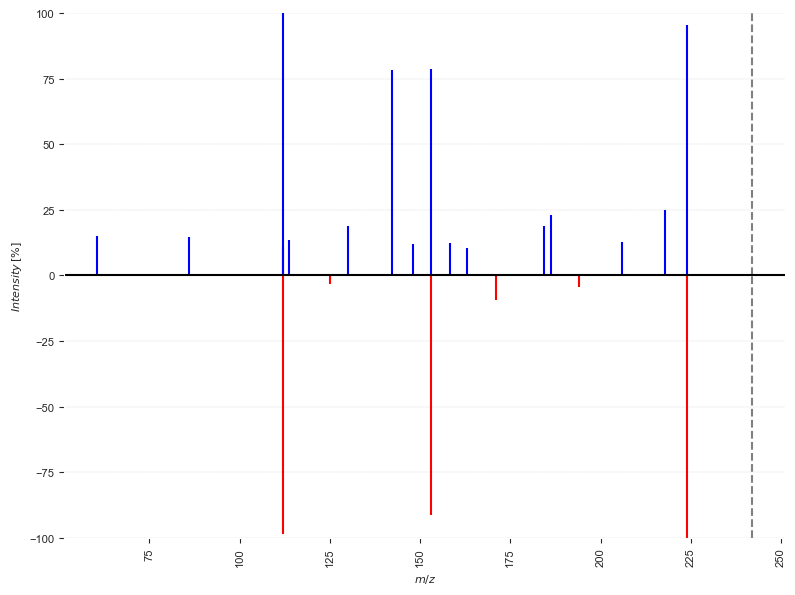

In [365]:
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz = row['precursor_mz'])

In [51]:
msms = []
msms_l = []
for index, row in tqdm(mass_wiki.iterrows(), total = len(mass_wiki)):
    msms.append(so.convert_nist_to_string(ast.literal_eval(row['peak'])))
    if row['library_peaks']==row['library_peaks']:
        msms_l.append(so.convert_nist_to_string(ast.literal_eval(row['library_peaks'])))
    else:
        msms_l.append(np.NAN)
    # break
mass_wiki['peak']=msms
mass_wiki['library_peaks']=msms_l

100%|██████████| 6561/6561 [00:03<00:00, 1688.61it/s]


In [52]:
mass_wiki_orb = string_search(mass_wiki, 'method', '5m hilic | orbitrap | beh amide | positive')
peaks_denoised = []
eis = []
simialrity_raw = []
similarity_denoised = []
for index, row in tqdm(mass_wiki_orb.iterrows(), total = len(mass_wiki_orb)):
    try:
        msms_d, ei = drf.spectra_denoising(row['peak'], row['smiles'], row['adduct'])
    except:
        msms_d = np.NAN
        ei = np.NAN
    peaks_denoised.append(msms_d)
    eis.append(ei)
    if row['library_peaks']==row['library_peaks'] and msms_d == msms_d:
        simialrity_raw.append(so.entropy_identity(row['peak'], row['library_peaks'], pmz = row['precursor_mz']))
        similarity_denoised.append(so.entropy_identity(msms_d, row['library_peaks'], pmz = row['precursor_mz']))
    else:
        simialrity_raw.append(np.NAN)
        similarity_denoised.append(np.NAN)

  5%|▌         | 108/2066 [00:03<01:13, 26.50it/s]

cannot determine adduct polarity!


  8%|▊         | 158/2066 [00:04<00:49, 38.24it/s]

cannot determine adduct polarity!


 13%|█▎        | 269/2066 [00:09<01:23, 21.55it/s]

cannot determine adduct polarity!


 38%|███▊      | 777/2066 [00:17<00:24, 51.73it/s] 

cannot determine adduct polarity!


 43%|████▎     | 884/2066 [00:19<00:33, 35.61it/s]

cannot determine adduct polarity!
cannot determine adduct polarity!


 46%|████▌     | 941/2066 [00:22<00:45, 24.93it/s]

cannot determine adduct polarity!


 50%|████▉     | 1024/2066 [00:25<00:30, 33.68it/s]

cannot determine adduct polarity!


 54%|█████▎    | 1106/2066 [00:29<00:32, 29.21it/s]

cannot determine adduct polarity!


 62%|██████▏   | 1282/2066 [00:35<00:23, 32.68it/s]

cannot determine adduct polarity!


 64%|██████▍   | 1318/2066 [00:36<00:24, 30.61it/s]

cannot determine adduct polarity!


 64%|██████▍   | 1327/2066 [00:37<00:29, 25.15it/s]

cannot determine adduct polarity!


 66%|██████▌   | 1354/2066 [00:38<00:26, 26.46it/s]

cannot determine adduct polarity!


 66%|██████▌   | 1368/2066 [00:38<00:23, 29.78it/s]

cannot determine adduct polarity!


 73%|███████▎  | 1502/2066 [00:42<00:14, 40.12it/s]

cannot determine adduct polarity!


 73%|███████▎  | 1518/2066 [00:42<00:13, 40.28it/s]

cannot determine adduct polarity!


 74%|███████▍  | 1535/2066 [00:43<00:12, 43.06it/s]

cannot determine adduct polarity!


 75%|███████▍  | 1544/2066 [00:44<00:28, 18.12it/s]

cannot determine adduct polarity!


 75%|███████▌  | 1555/2066 [00:44<00:39, 13.01it/s]

cannot determine adduct polarity!


 77%|███████▋  | 1586/2066 [00:45<00:12, 38.40it/s]

cannot determine adduct polarity!


 80%|███████▉  | 1649/2066 [00:47<00:08, 48.05it/s]

cannot determine adduct polarity!


 81%|████████  | 1668/2066 [00:47<00:12, 31.82it/s]

cannot determine adduct polarity!


 81%|████████▏ | 1682/2066 [00:48<00:19, 19.79it/s]

cannot determine adduct polarity!


 82%|████████▏ | 1694/2066 [00:49<00:16, 22.26it/s]

cannot determine adduct polarity!
cannot determine adduct polarity!


 84%|████████▎ | 1727/2066 [00:50<00:07, 42.39it/s]

cannot determine adduct polarity!


 88%|████████▊ | 1818/2066 [00:52<00:05, 46.97it/s]

cannot determine adduct polarity!


 91%|█████████ | 1883/2066 [00:54<00:04, 39.94it/s]

cannot determine adduct polarity!


 94%|█████████▍| 1950/2066 [00:55<00:02, 46.95it/s]

cannot determine adduct polarity!


 98%|█████████▊| 2030/2066 [00:57<00:00, 62.11it/s]

cannot determine adduct polarity!
cannot determine adduct polarity!
cannot determine adduct polarity!


100%|██████████| 2066/2066 [00:58<00:00, 35.25it/s]


In [53]:
mass_wiki_orb['peaks_denoised']=peaks_denoised
mass_wiki_orb.insert(0, 'eis', eis)
mass_wiki_orb['simialrity_raw']=simialrity_raw
mass_wiki_orb['similarity_denoised']=similarity_denoised

In [54]:
mass_wiki_orb['similarity_offset']= mass_wiki_orb['similarity_denoised']-mass_wiki_orb['simialrity_raw']

In [55]:
mass_wiki_orb.sort_values(by = 'similarity_offset', ascending=False, inplace=True)

In [56]:
mass_wiki_orb.reset_index(inplace=True, drop = True)

melamine
entropy similarity is  0.5115791922705049
entropy similarity is  0.8608804722466779


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

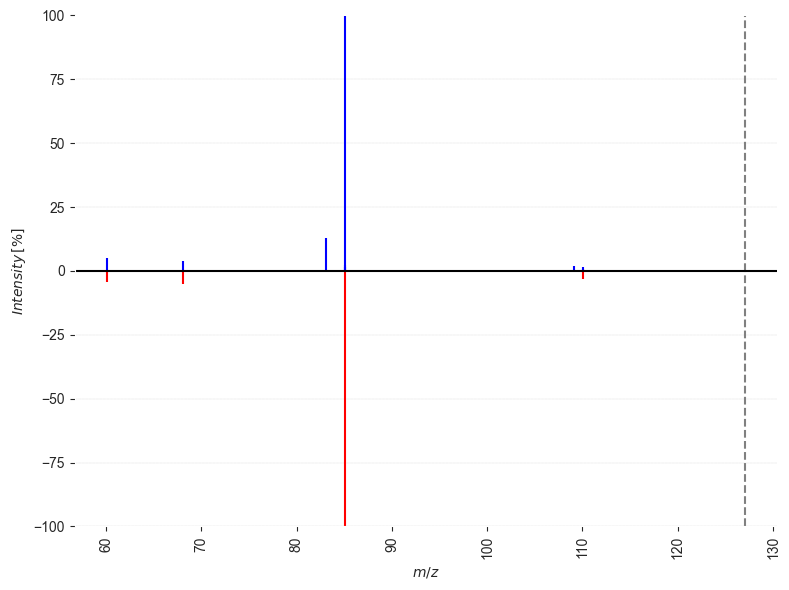

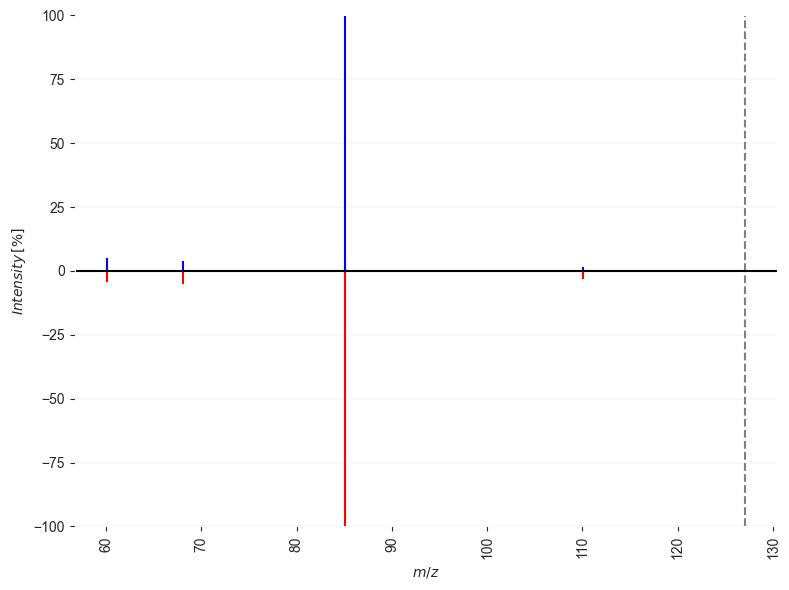

In [58]:
row = mass_wiki_orb.loc[28]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

2-aminoheptanoic acid
entropy similarity is  0.7525419906205182
entropy similarity is  0.9127236953091264


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

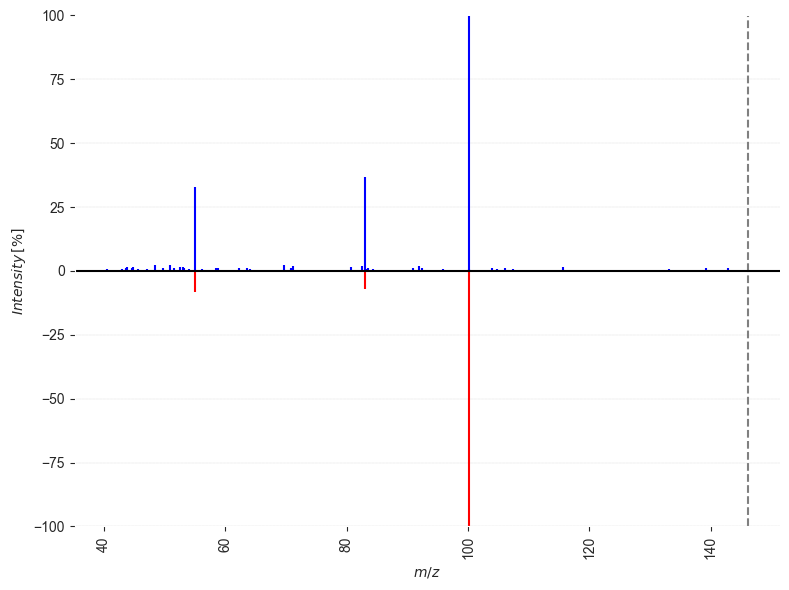

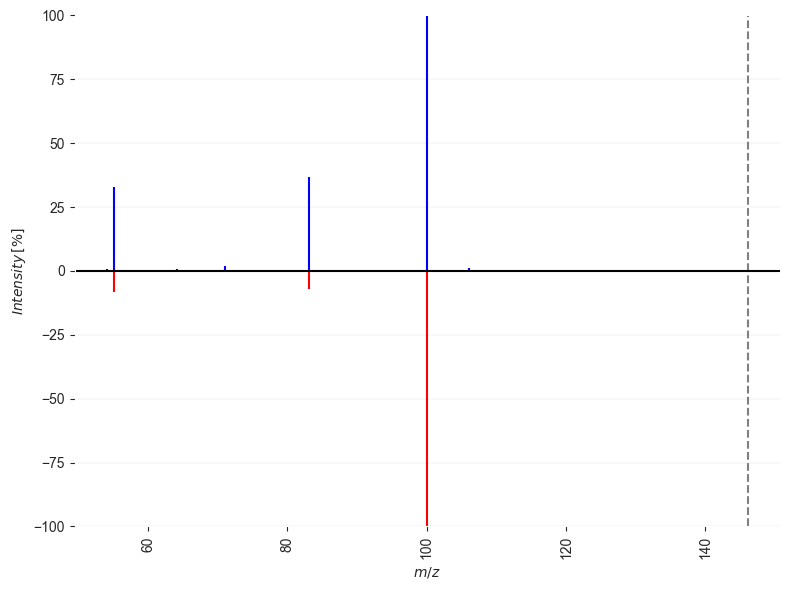

In [367]:
row = mass_wiki_orb.loc[187]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

indoline
entropy similarity is  0.47482669697001223
entropy similarity is  0.6763065635569303
entropy similarity is  0.8637814734178423


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

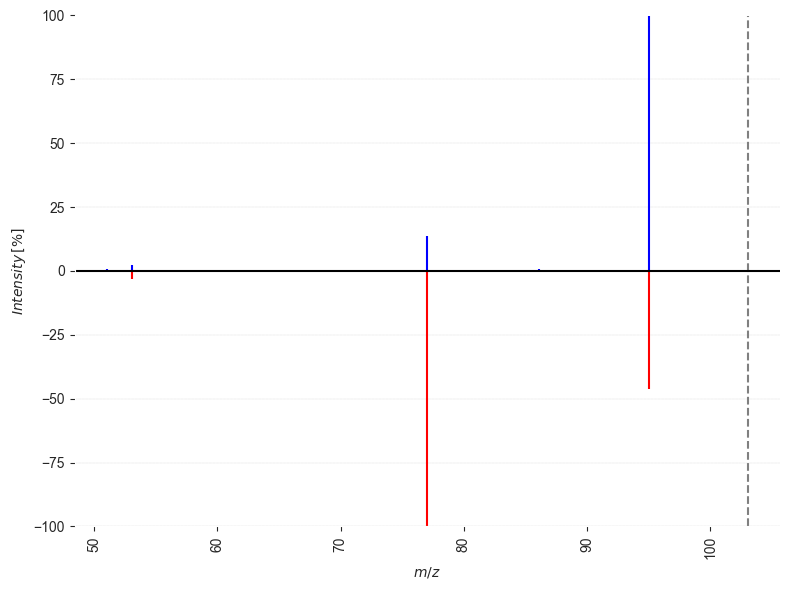

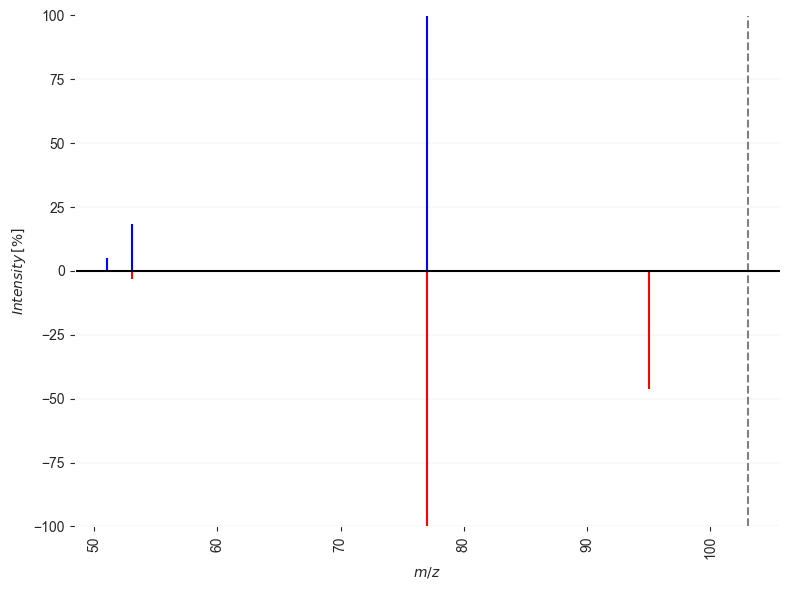

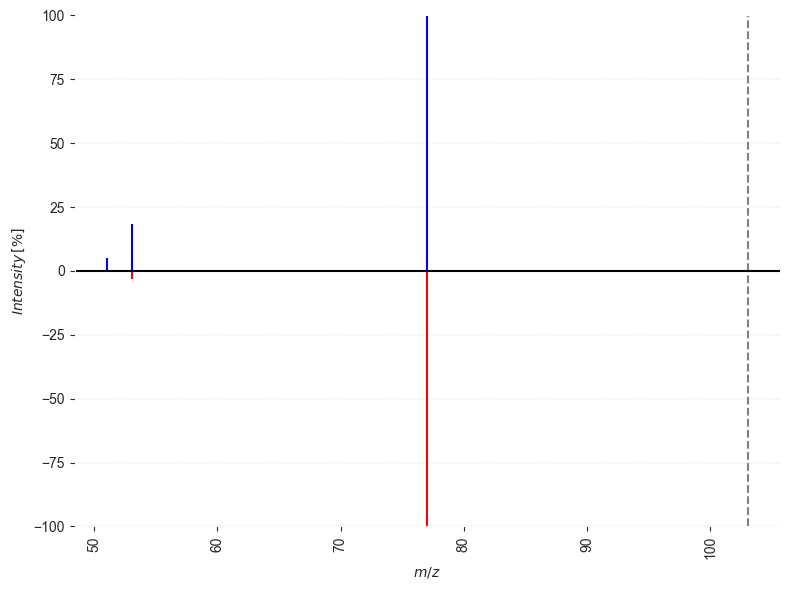

In [16]:
from toolsets.chem_helpers import everything_to_image
row = mass_wiki_orb.loc[121]
print(row['name'])
# everything_to_image(row['smiles'], savepath=os.path.join(master_dir, row['name']+'.png'))
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'],
                          savepath=os.path.join(master_dir, 'raw_nist.png')
                          )
denoised = drf.spectra_denoising(row['library_peaks'], row['smiles'], row['adduct'])[0]
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'],
                          savepath=os.path.join(master_dir, 'denoised_nist.png')
                          )
plotter.head_to_tail_plot(row['peaks_denoised'], denoised, pmz=row['precursor_mz'],
                          savepath=os.path.join(master_dir, 'both_denoised.png')
                          )g

In [17]:
row['library_peaks']

'77.03810119628906\t0.6695778965950012\n95.04869842529297\t0.30858808755874634\n53.038299560546875\t0.021834062412381172'

In [1]:
95.04869842529297-1.007276

94.04142242529296

In [22]:
import toolsets.chem_helpers as ch
ch.everything_to_formula(row['smiles'])

'C8H9N'

pantothenic acid
entropy similarity is  0.6077192660706843
entropy similarity is  0.7735330785792505


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

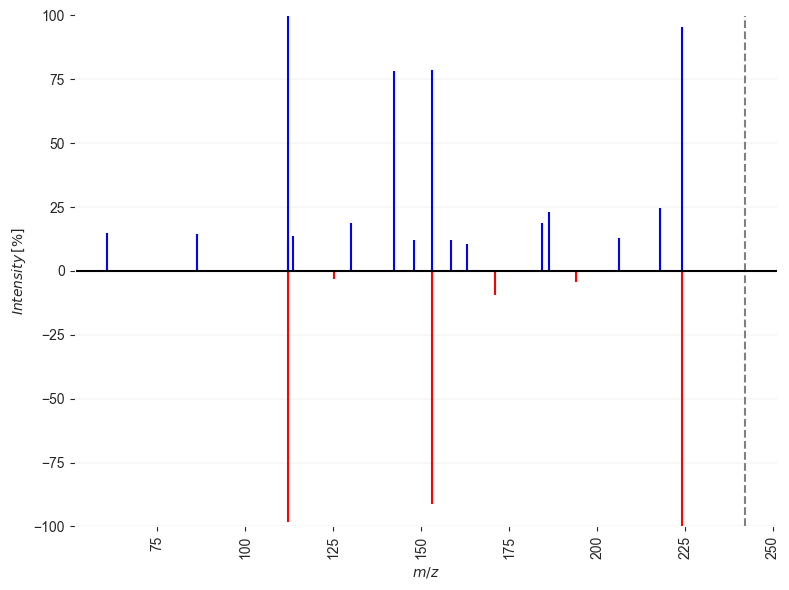

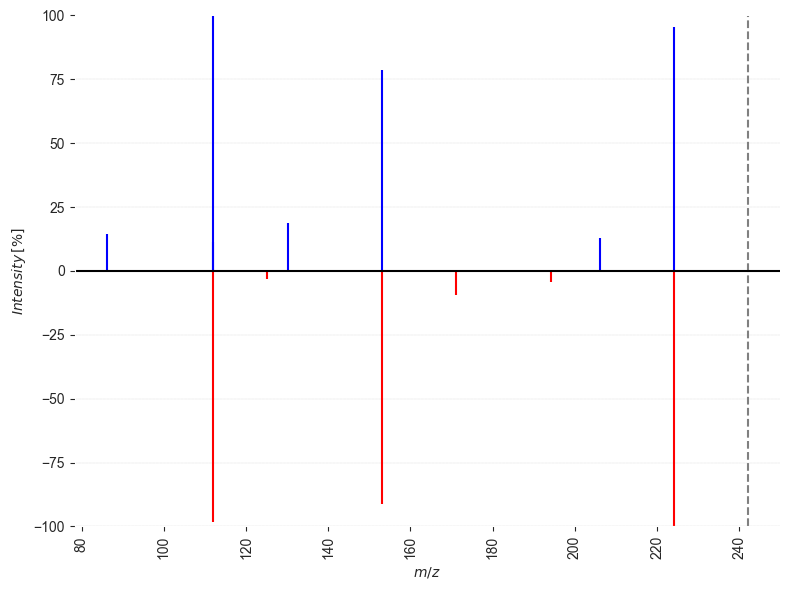

In [321]:
row = mass_wiki_orb.loc[178]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

In [369]:
mass_wiki_orb.loc[78]

eis                                                              0.61015
scan                                                              8267.0
rt                                                            111.860443
precursor_mz                                                  147.120888
charge                                                                 1
peak                   147.12130737304688\t19777.009765625\n87.044197...
username                                                    Oliver Fiehn
name                                                       acetylcholine
comments               The compound matched with the MassBank.us libr...
smiles                                              CC(=O)OCC[N+](C)(C)C
adduct                                                            [M+H]+
method                        5m hilic | orbitrap | beh amide | positive
version                                                          LCB2023
splash                     splash10-01pa-9600000000

In [371]:
drf.calculate_precursormz(row['smiles'], row['adduct'], if_smiles=True)

147.12538021157076

In [372]:
smile_to_formula(row['smiles'])

'C7H16NO2+'

acetylcholine
entropy similarity is  0.7078765623297647
entropy similarity is  0.9485414035854685


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

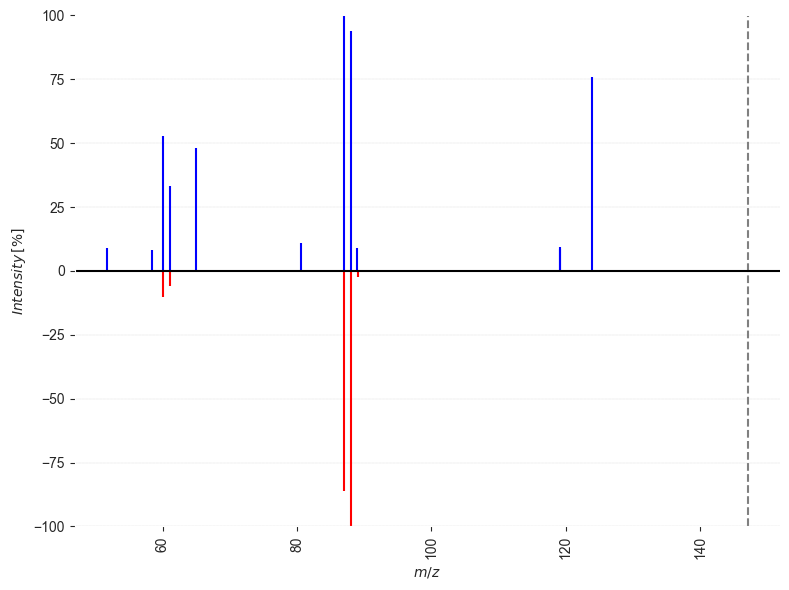

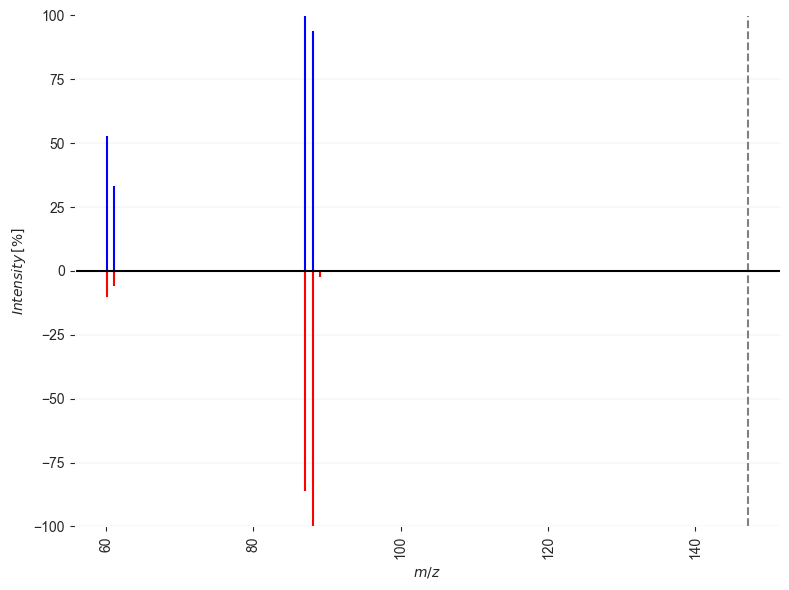

In [317]:
row = mass_wiki_orb.loc[78]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

benzimidazole
entropy similarity is  0.7072717062602425
entropy similarity is  0.9711073992439553


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

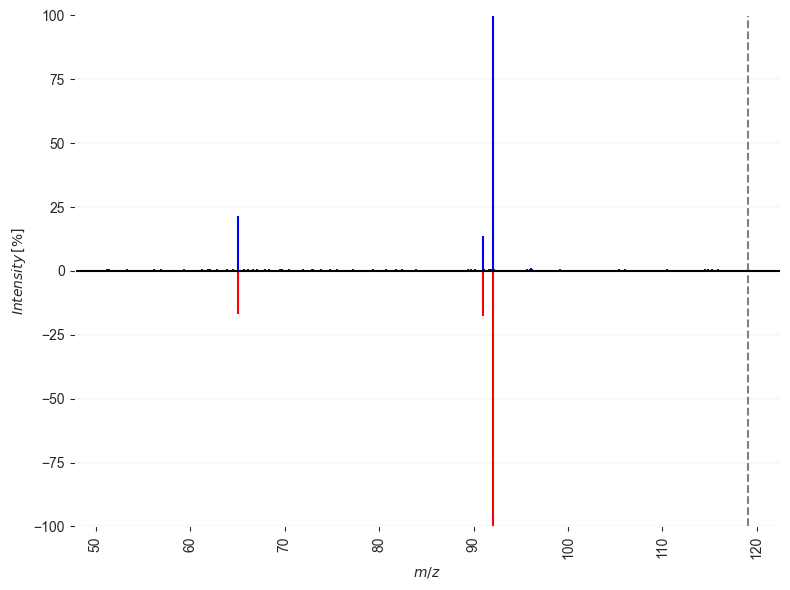

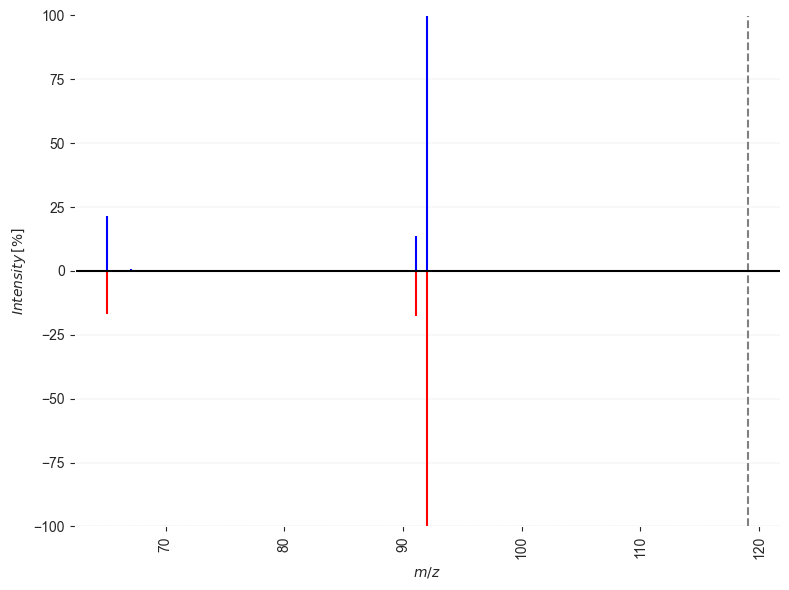

In [316]:
row = mass_wiki_orb.loc[66]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

1-(2-chlorophenyl)biguanide
entropy similarity is  0.6531390449904506
entropy similarity is  0.9186360839001515


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

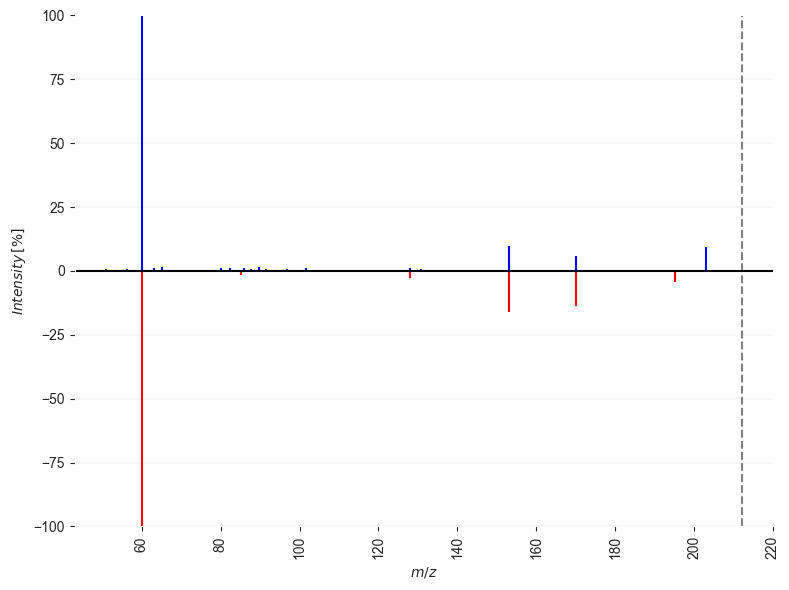

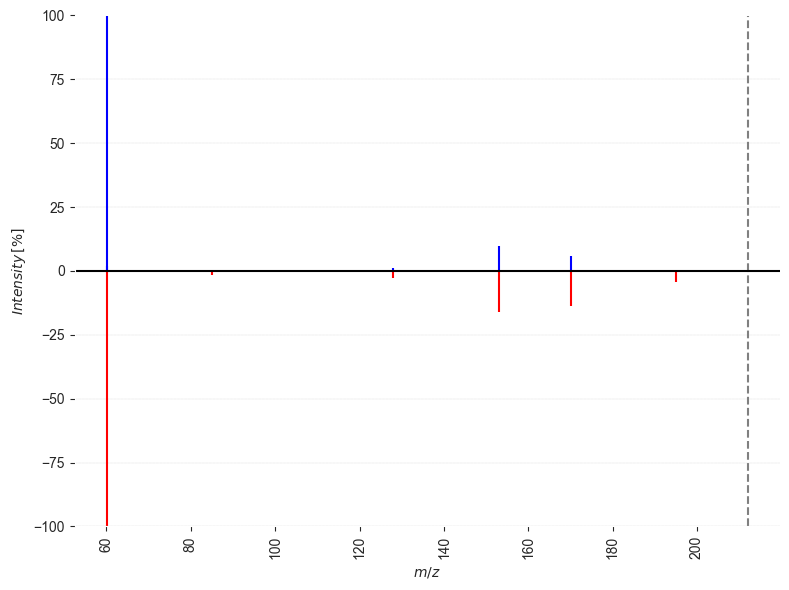

In [315]:
row = mass_wiki_orb.loc[63]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

1,4,7-triazacyclononane
entropy similarity is  0.5252969351864256
entropy similarity is  0.8173237775352451


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

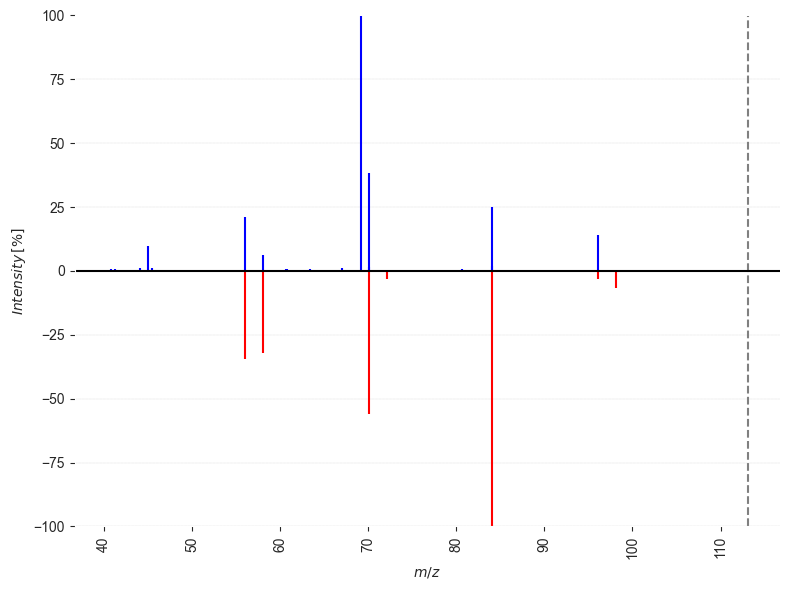

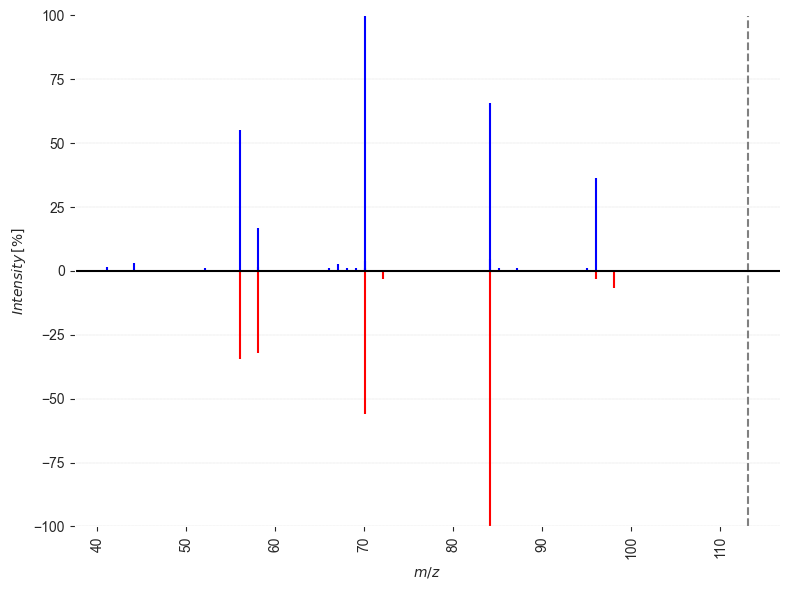

In [314]:
row = mass_wiki_orb.loc[50]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

2-methylpyrrolidine
entropy similarity is  0.47464793363906105
entropy similarity is  0.7933477450813979


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

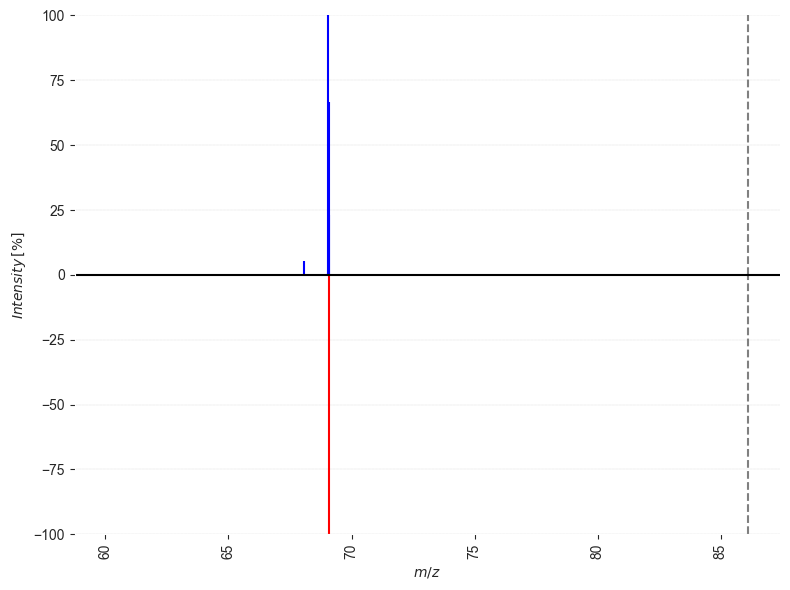

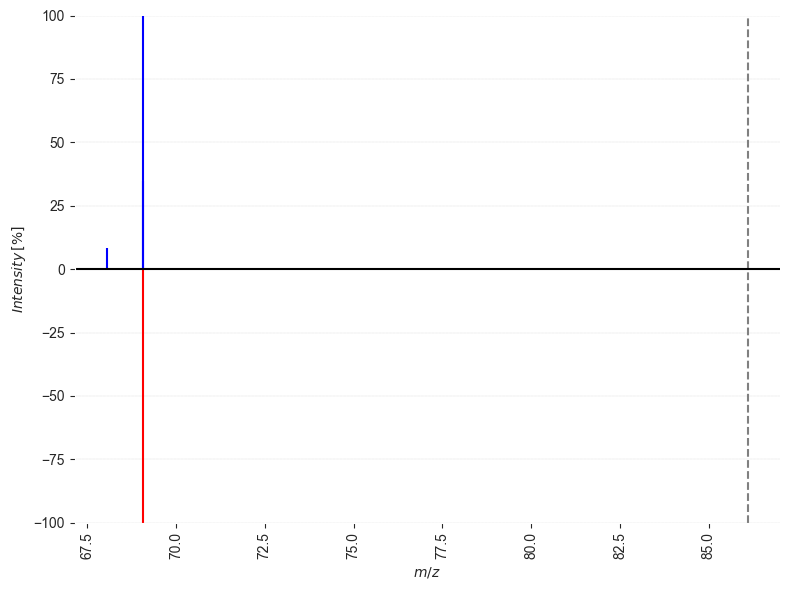

In [312]:
row = mass_wiki_orb.loc[38]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

piperidine
entropy similarity is  0.4802940894462996
entropy similarity is  0.83827960823784


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

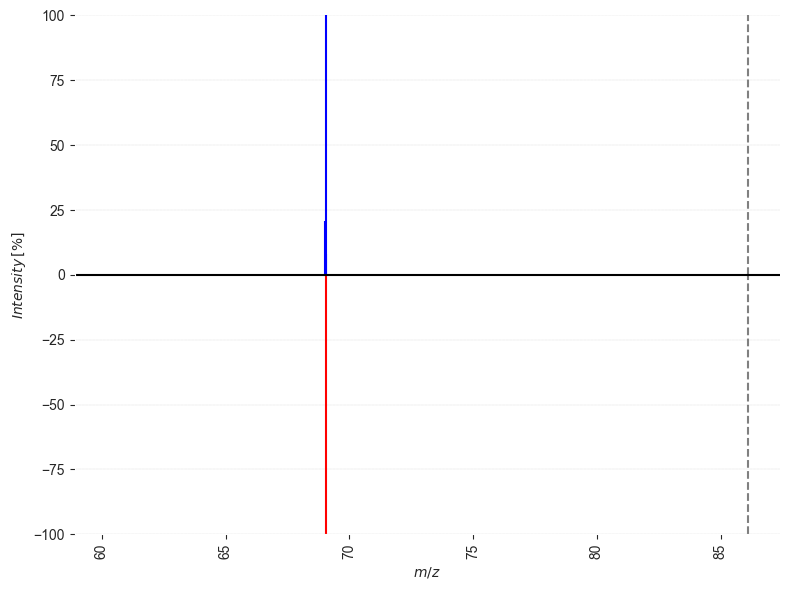

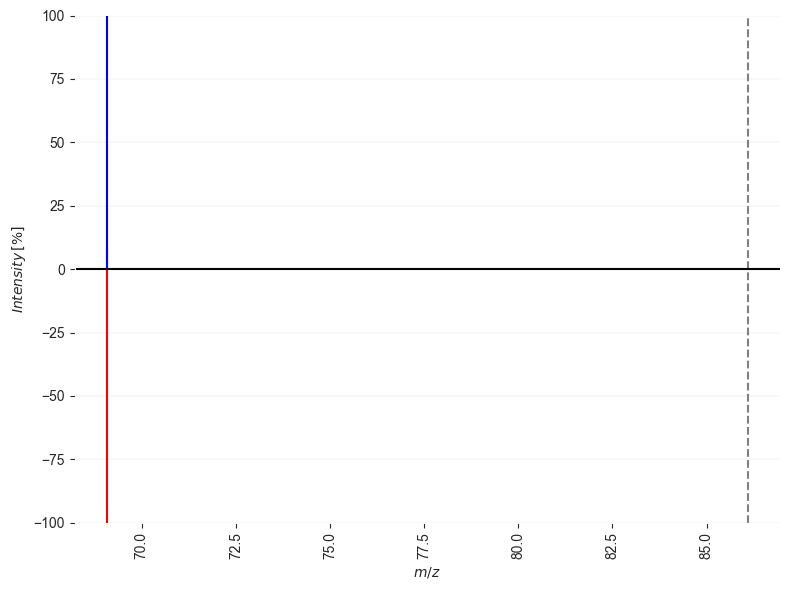

In [289]:
row = mass_wiki_orb.loc[26]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

cyclohexane-1,2-dione
entropy similarity is  0.5421357513317971
entropy similarity is  0.8993528849025664


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

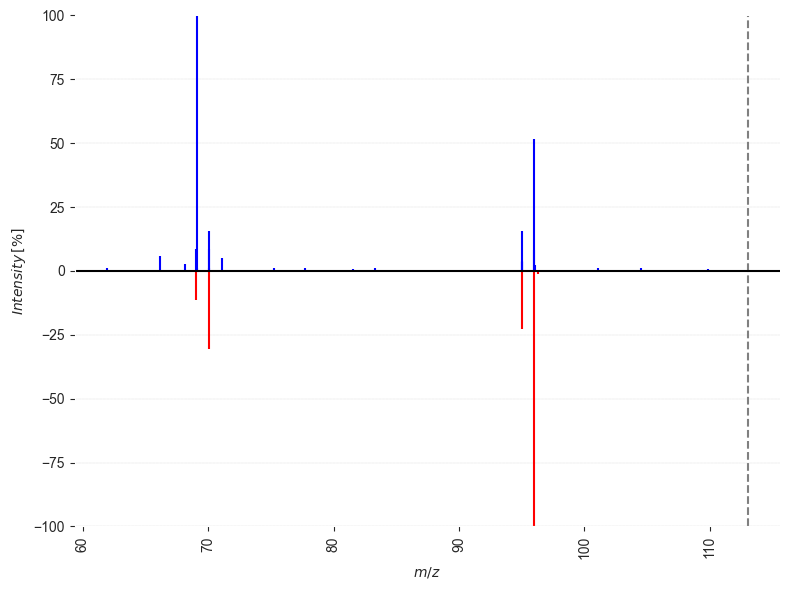

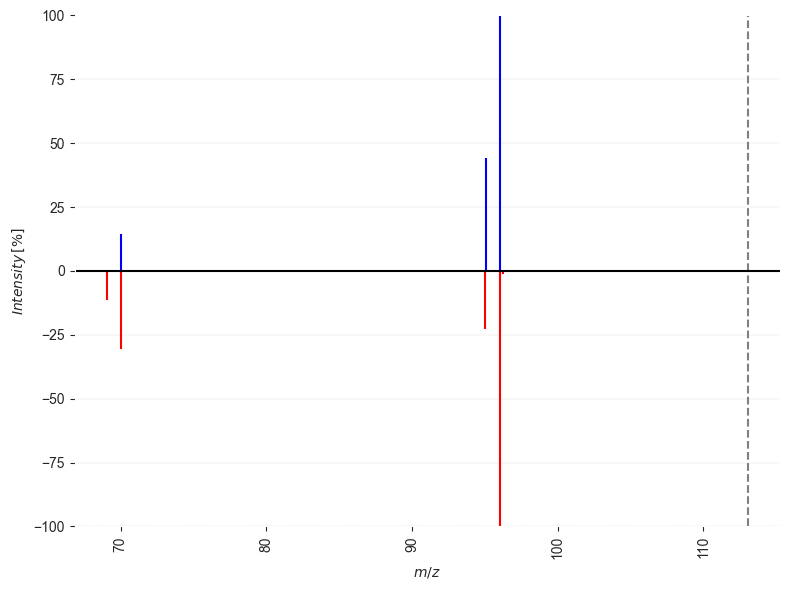

In [287]:
row = mass_wiki_orb.loc[27]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])

N4-acetylcytidine
entropy similarity is  0.6396516240448831
entropy similarity is  1.0


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

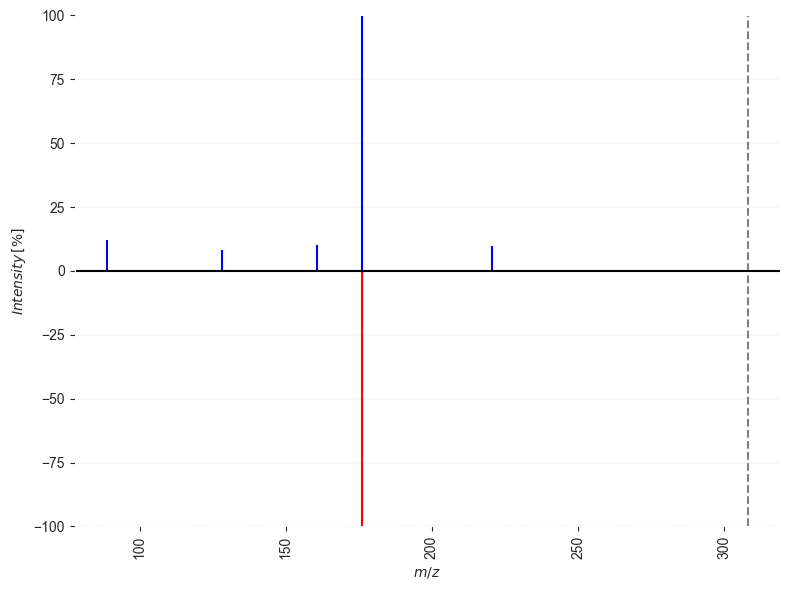

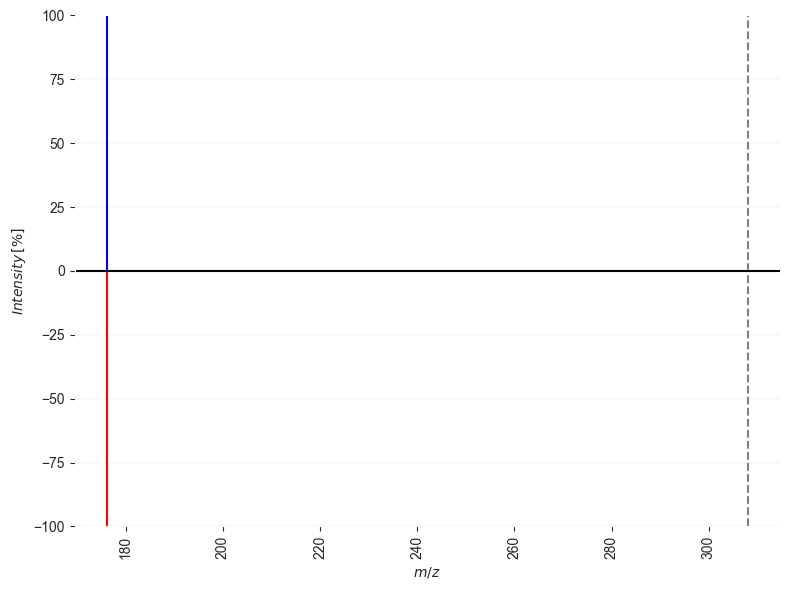

In [288]:
row = mass_wiki_orb.loc[25]
print(row['name'])
plotter.head_to_tail_plot(row['peak'], row['library_peaks'], pmz=row['precursor_mz'])
plotter.head_to_tail_plot(row['peaks_denoised'], row['library_peaks'], pmz=row['precursor_mz'])